#### 任务目标：基于所给数据集对饭店流量指标进行预测

不限方法，不限工具包使用。最终目标需给出预测结果，此题重在考察数据处理与建模能力

- air_visit_data.csv数据集为饭店每天客流数据，其中visitors为标签
- air_store_info.csv数据集为饭店所处位置信息数据
- date_info.csv数据集为日历数据
- sample_submission.csv为测试数据集，即提交结果（注意其格式，处理时需要把ID和日期分别提取，即预测每个饭店每天的流量情况）
- weather文件夹为气象台下载数据，有能力的同学可以尝试加入天气特征，时间紧的话可以暂时不考虑这个

提示：请尝试对各个数据集进行特征提取，并整合特征，其中日期与时间指标可以做出来很多特征，大家可以多多尝试，需要提交的测试数据及并非标准格式，需要一些基本的预处理，即预测每个饭店每天的流量情况，处理测试集的时候需先对测试集补全所需特征，例如是否为节假日，星期几，区域信息等。



# 目录
[一、导入模块](#一、导入模块)<br>
[二、理解数据](#二、理解数据)<br>
[三、数据可视化](#三、数据可视化)<br>
[四、特征工程开始](#四、特征工程开始)<br>
[五、加入天气特征](#五、加入天气特征)<br>
[六、准备训练数据](#六、准备训练数据)<br>
[七、对比不同算法](#七、对比不同算法)<br>
[八、优化模型调参](#八、优化模型调参)<br>
[九、提交数据做相同特征处理](#九、提交数据做相同特征处理)<br>
[十、计算提交数据](#十、计算提交数据)<br>
[十一、总结](#十一、总结)<br>

## 一、导入模块
[回到目录](#目录)

In [3]:
# 数据分析相关模块
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 机器学习相关模块

In [4]:
# 读取数据
visit = pd.read_csv('data_set/air_visit_data.csv')
info = pd.read_csv('data_set/air_store_info.csv')
dates = pd.read_csv('data_set/date_info.csv')
submission = pd.read_csv('data_set/sample_submission.csv')

## 二、理解数据
[回到目录](#目录)

### 1.检查客流量数据

In [51]:
visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [52]:
visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [53]:
# 检查缺失值
visit.isnull().sum()

air_store_id    0
visit_date      0
visitors        0
dtype: int64

In [54]:
# 查看客流的统计指标
visit.describe()

,visitors
count,252108.000000
mean,20.973761
std,16.757007
min,1.000000
25%,9.000000
50%,17.000000
75%,29.000000
max,877.000000


In [55]:
# 检查每个店铺的数据量，发现有的店铺有超过1年的数据，有些店铺不到1个月的数据
visit['air_store_id'].value_counts()

air_5c817ef28f236bdf    477
air_a083834e7ffe187e    476
air_36bcf77d3382d36e    476
air_d97dabf7aae60da5    476
air_232dcee6f7c51d37    475
                       ... 
air_1c0b150f9e696a5f     51
air_a17f0778617c76e2     47
air_789103bf53b8096b     41
air_a9a380530c1e121f     40
air_900d755ebd2f7bbd     20
Name: air_store_id, Length: 829, dtype: int64

In [56]:
# 检查店铺时间数据，发现有全部时间数据的店，可能只有48个
visit['visit_date'].value_counts()

2017-03-17    799
2017-04-14    791
2017-03-03    791
2017-03-24    789
2017-03-31    786
             ... 
2016-01-04    157
2017-01-01    147
2016-01-03     81
2016-01-02     63
2016-01-01     48
Name: visit_date, Length: 478, dtype: int64

In [57]:
# 查看训练数据的时间范围
pd.to_datetime(visit['visit_date'])

0        2016-01-13
1        2016-01-14
2        2016-01-15
3        2016-01-16
4        2016-01-18
            ...    
252103   2017-04-18
252104   2017-04-19
252105   2017-04-20
252106   2017-04-21
252107   2017-04-22
Name: visit_date, Length: 252108, dtype: datetime64[ns]

In [58]:
# 查看客流的分布的情况
visit['visitors'].value_counts()

8      8685
6      8684
10     8543
9      8532
7      8521
       ... 
351       1
189       1
188       1
229       1
216       1
Name: visitors, Length: 204, dtype: int64

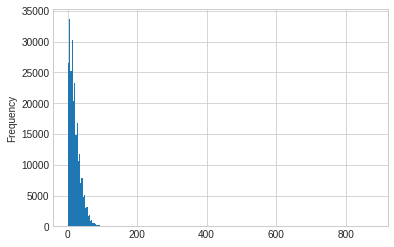

In [59]:
visit['visitors'].plot(kind='hist', bins=250)

### 2.检查店铺情况数据

In [60]:
info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [61]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [62]:
# 检查缺失值
info.isnull().sum()

air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64

In [5]:
# 查看店铺经纬，发现从最大最小值得知，店铺分布在日本最大的岛
info.describe()

,latitude,longitude
count,829.000000,829.000000
mean,35.647042,137.415311
std,2.084659,3.650971
min,33.211967,130.195555
25%,34.695124,135.341564
50%,35.658068,139.685474
75%,35.694003,139.751599
max,44.020632,144.273398


In [64]:
# 检查店铺名，共829个店与客流数据里的店铺数量一致
info['air_store_id'].value_counts()

air_2fc478dc9f0a6b31    1
air_08f994758a1e76d4    1
air_d00161e19f08290b    1
air_e5cf003abcc5febb    1
air_df5cf5cd03eb68d0    1
                       ..
air_b5bdd318005d9aa4    1
air_2703dcb33192b181    1
air_cd5f54969be9ed08    1
air_2a7f14da7fe0f699    1
air_15ae33469e9ea2dd    1
Name: air_store_id, Length: 829, dtype: int64

In [65]:
# 查看店铺的类型，共14类
info['air_genre_name'].value_counts()

Izakaya                         197
Cafe/Sweets                     181
Dining bar                      108
Italian/French                  102
Bar/Cocktail                     79
Japanese food                    63
Other                            27
Yakiniku/Korean food             23
Western food                     16
Okonomiyaki/Monja/Teppanyaki     14
Creative cuisine                 13
Karaoke/Party                     2
Asian                             2
International cuisine             2
Name: air_genre_name, dtype: int64

In [66]:
# 店铺分面103个地点，可以与天气数据做合并
info['air_area_name'].value_counts()

Fukuoka-ken Fukuoka-shi Daimyō           64
Tōkyō-to Shibuya-ku Shibuya              58
Tōkyō-to Minato-ku Shibakōen             51
Tōkyō-to Shinjuku-ku Kabukichō           39
Tōkyō-to Setagaya-ku Setagaya            30
                                         ..
Tōkyō-to Setagaya-ku Kitazawa             2
Ōsaka-fu Higashiōsaka-shi Aramotokita     2
Tōkyō-to Shibuya-ku Dōgenzaka             2
Tōkyō-to Katsushika-ku Tateishi           2
Tōkyō-to Shibuya-ku Jingūmae              2
Name: air_area_name, Length: 103, dtype: int64

### 3.检查日期数据

In [67]:
dates.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [68]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   calendar_date  517 non-null    object
 1   day_of_week    517 non-null    object
 2   holiday_flg    517 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.2+ KB


In [69]:
dates.isnull().sum()

calendar_date    0
day_of_week      0
holiday_flg      0
dtype: int64

In [70]:
dates['holiday_flg'].value_counts()

0    482
1     35
Name: holiday_flg, dtype: int64

### 4.查看要提交的目标数据

In [71]:
submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [72]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        32019 non-null  object
 1   visitors  32019 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.4+ KB


In [73]:
# 检查要预测数据时间的时间范围
pd.to_datetime(submission['id'].str.split('_').str[2])

0       2017-04-23
1       2017-04-24
2       2017-04-25
3       2017-04-26
4       2017-04-27
           ...    
32014   2017-05-27
32015   2017-05-28
32016   2017-05-29
32017   2017-05-30
32018   2017-05-31
Name: id, Length: 32019, dtype: datetime64[ns]

#### 小结：从数据的情况来看，完好无缺失值。训练数据约25万多条，要预测的数据为3万多条。训练数据的时间长度约16个月，要预测的数据长度约2个月，但不是每个店铺都有16个月的数据，有些只有不到1个月的数据，需要多方面构建数据。

## 三、数据可视化
[回到目录](#目录)

### 1.显示不同开店时长的店铺客流

In [74]:
some_store = visit.groupby('air_store_id')[
    'visit_date'].count().sort_values(ascending=False)
some_store = pd.DataFrame(some_store)
some_store

,visit_date
air_store_id,
air_5c817ef28f236bdf,477
air_a083834e7ffe187e,476
air_36bcf77d3382d36e,476
air_d97dabf7aae60da5,476
air_71903025d39a4571,475
...,...
air_1c0b150f9e696a5f,51
air_a17f0778617c76e2,47
air_789103bf53b8096b,41


In [75]:
# 开店时间最多的为老店铺
old_store = some_store.head(9).index.to_list()
old_store

['air_5c817ef28f236bdf',
 'air_a083834e7ffe187e',
 'air_36bcf77d3382d36e',
 'air_d97dabf7aae60da5',
 'air_71903025d39a4571',
 'air_232dcee6f7c51d37',
 'air_60a7057184ec7ec7',
 'air_883ca28ef0ed3d55',
 'air_7a946aada80376a4']

In [76]:
# 开店时间最少的为新店铺
new_store = some_store.tail(9).index.to_list()
new_store

['air_bb4ff06cd661ee9b',
 'air_8e8f42f047537154',
 'air_8e492076a1179383',
 'air_cf5ab75a0afb8af9',
 'air_1c0b150f9e696a5f',
 'air_a17f0778617c76e2',
 'air_789103bf53b8096b',
 'air_a9a380530c1e121f',
 'air_900d755ebd2f7bbd']

In [77]:
# 抽取部分店铺进行比较
sample_store = some_store.sample(9).index.to_list()
sample_store

['air_dad0b6a36138f309',
 'air_ee3a01f0c71a769f',
 'air_08f994758a1e76d4',
 'air_42c9aa6d617c5057',
 'air_77dfc83450cbc89c',
 'air_36429b5ca4407b3e',
 'air_347be2c4feeb408b',
 'air_6d65dd11d96e00fb',
 'air_47070be6093f123e']

In [78]:
# 绘制多图函数
def plot_stores_visitors(store_lists, save_name):
    fig = plt.figure(figsize=(20, 16))
    for i in range(len(store_lists)):
        # 设置画面格式
        fig.subplots_adjust(left=None, bottom=None, right=None,
                            top=None, wspace=0.2, hspace=0.5)
        ax = fig.add_subplot(3, 3, i+1)
        df = visit.loc[visit['air_store_id'] == store_lists[i]]
        # x刻度表，只显示开始和结束时间
        xticks_list = ['']*(len(df)-2)
        xticks_list = [df['visit_date'].iloc[0]] + \
            xticks_list+[df['visit_date'].iloc[-1]]
        # 绘图
        ax.plot(df['visit_date'], df['visitors'])
        ax.set_ylabel('visitors')
        ax.set_xlabel('date')
        ax.set_xticks(xticks_list)
        ax.set_title('visitors of {}'.format(store_lists[i]))
#     plt.savefig('img/{}.png'.format(save_name), dpi=300, bbox_inches='tight')
    plt.show()

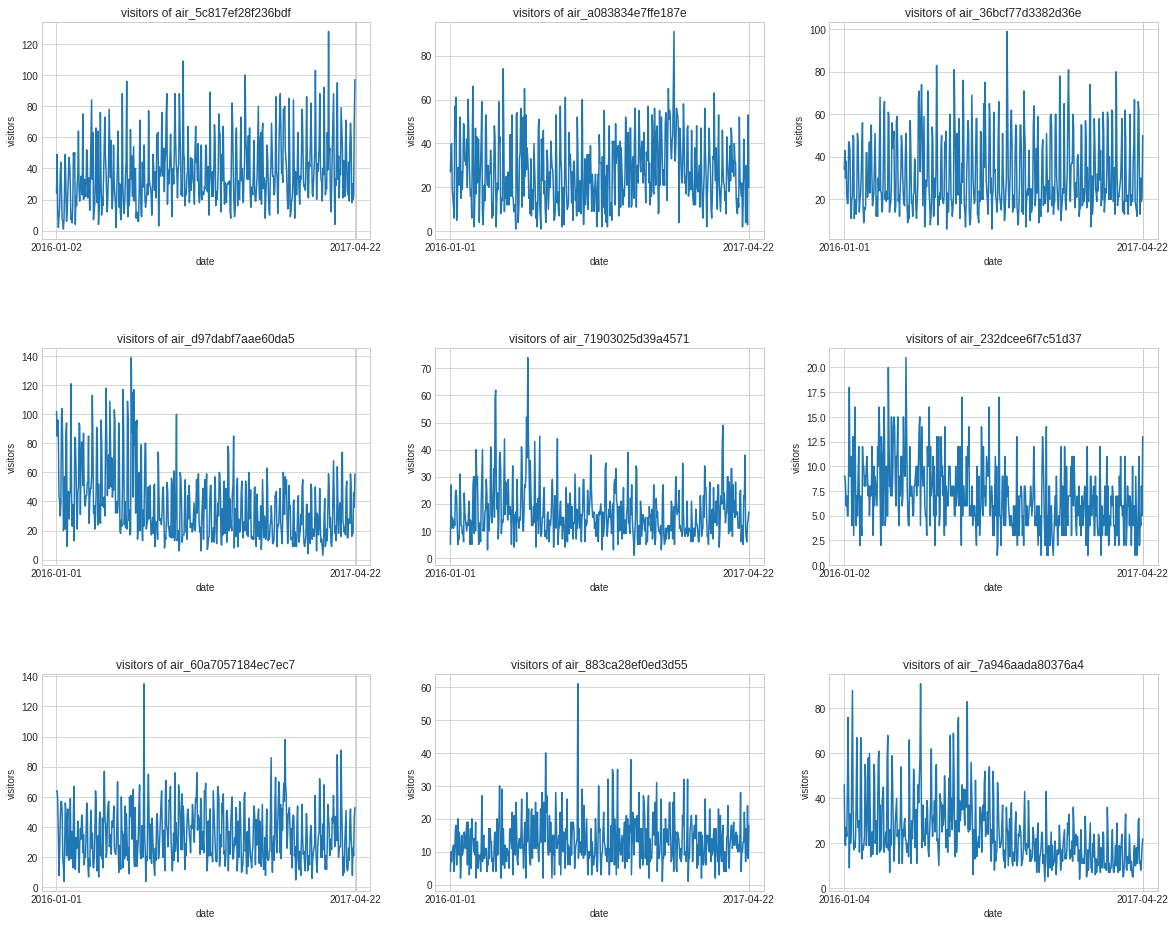

In [79]:
plot_stores_visitors(old_store, 'visitors_of_old_stores')

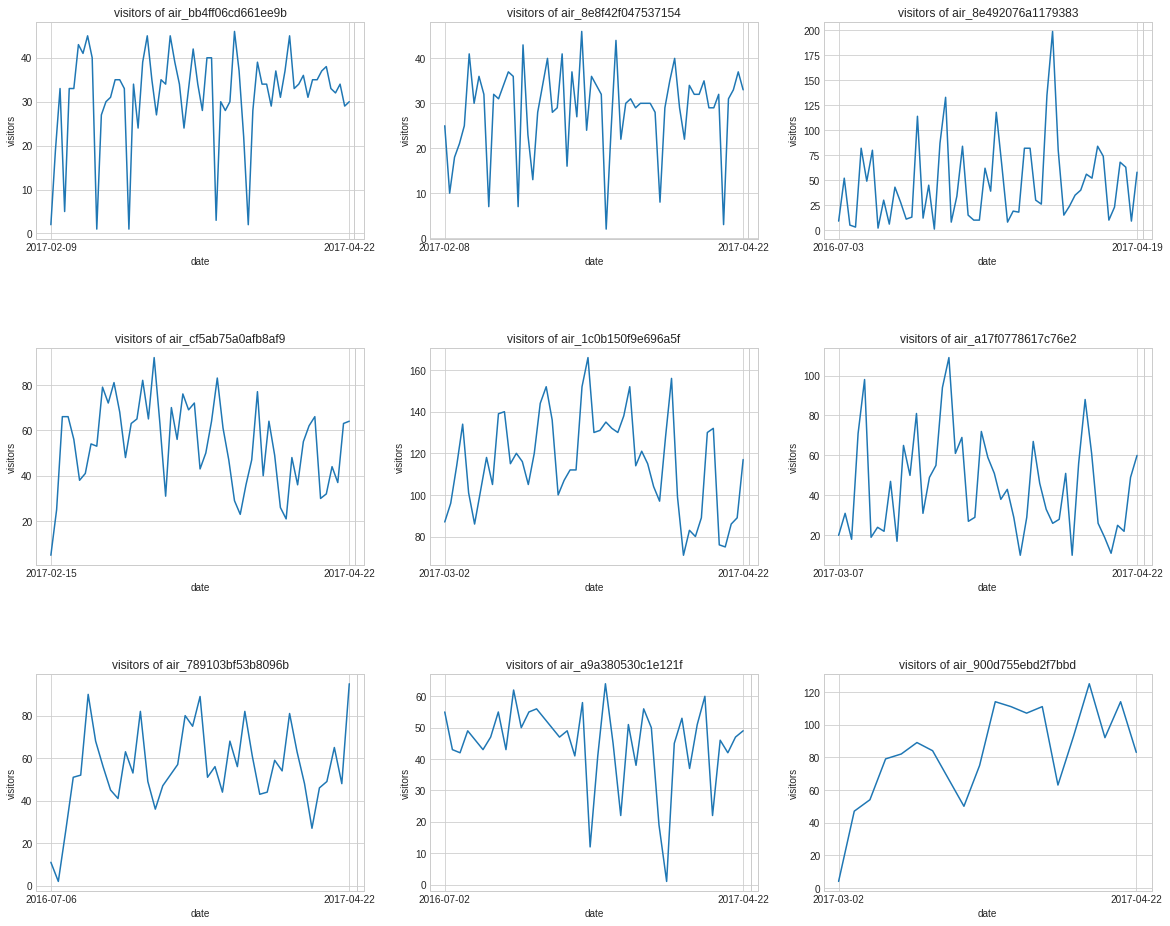

In [80]:
plot_stores_visitors(new_store, 'visitors_of_new_stores')

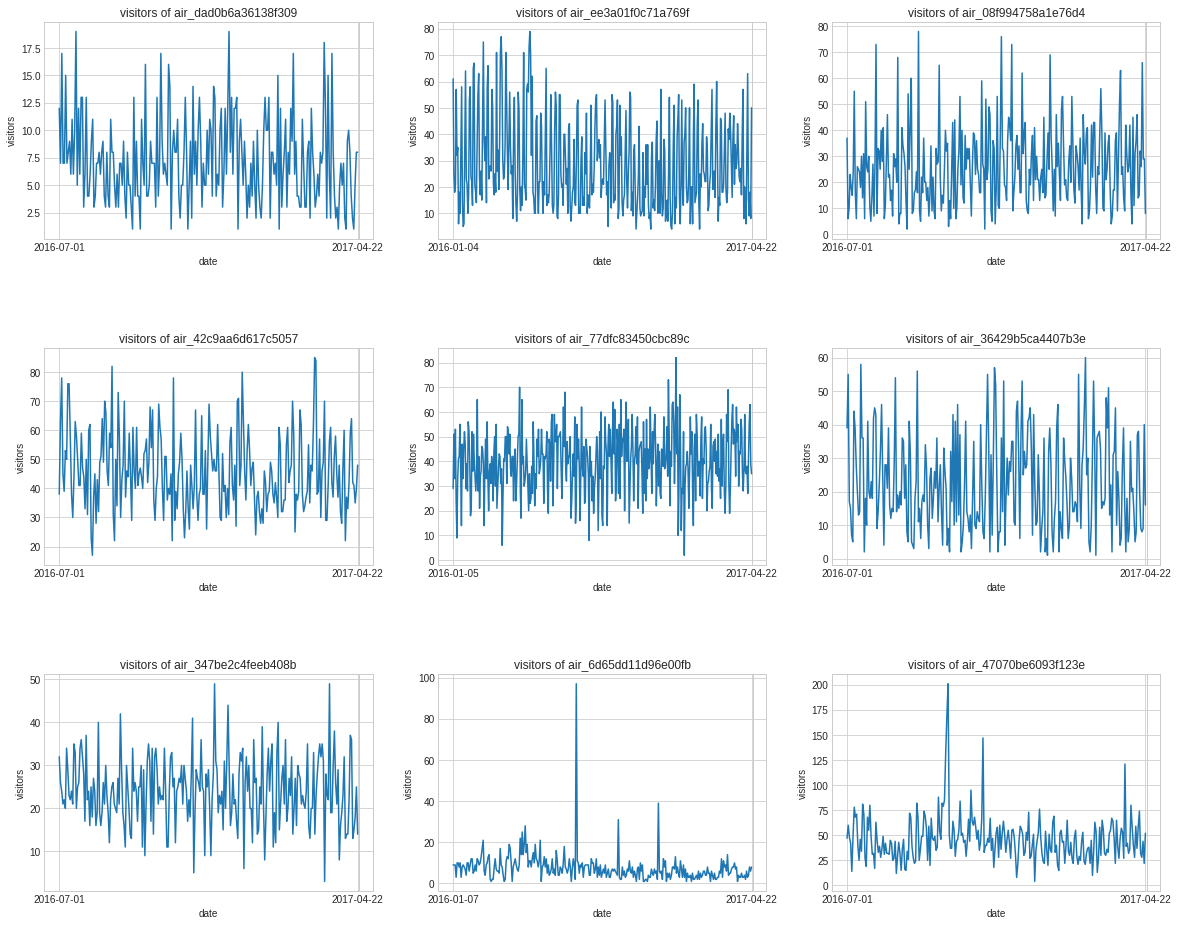

In [81]:
plot_stores_visitors(sample_store, 'visitors_of_sample_stores')

### 2.绘制店铺情况

In [82]:
genre_sr = info['air_genre_name'].value_counts()

Text(0, 0.5, '')

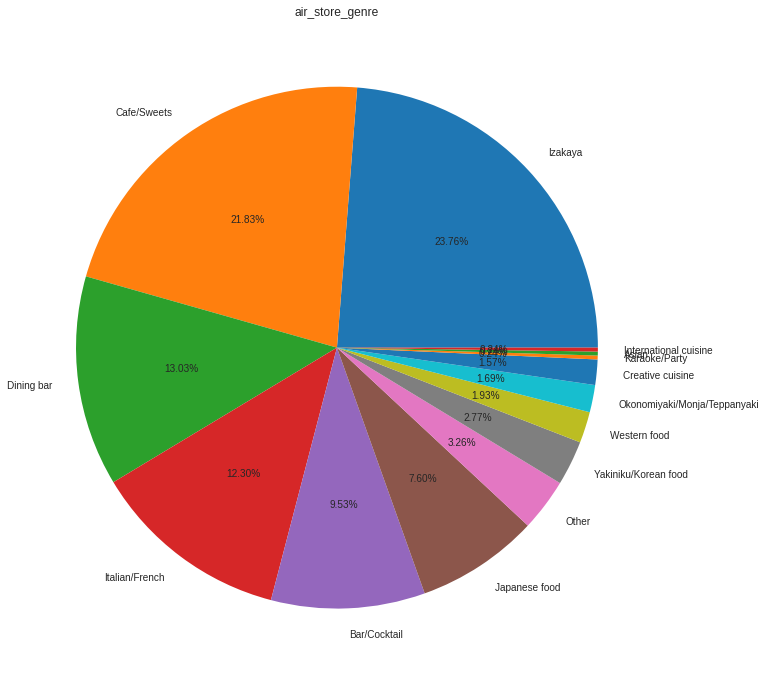

In [83]:
genre_sr.plot.pie(figsize=(12, 12), autopct='%.2f%%')
plt.title("air_store_genre")
plt.ylabel('')
# plt.savefig('img/air_store_genre.png', dpi=300, bbox_inches='tight')

In [84]:
area_sr = info['air_area_name'].value_counts()

Text(0, 0.5, '')

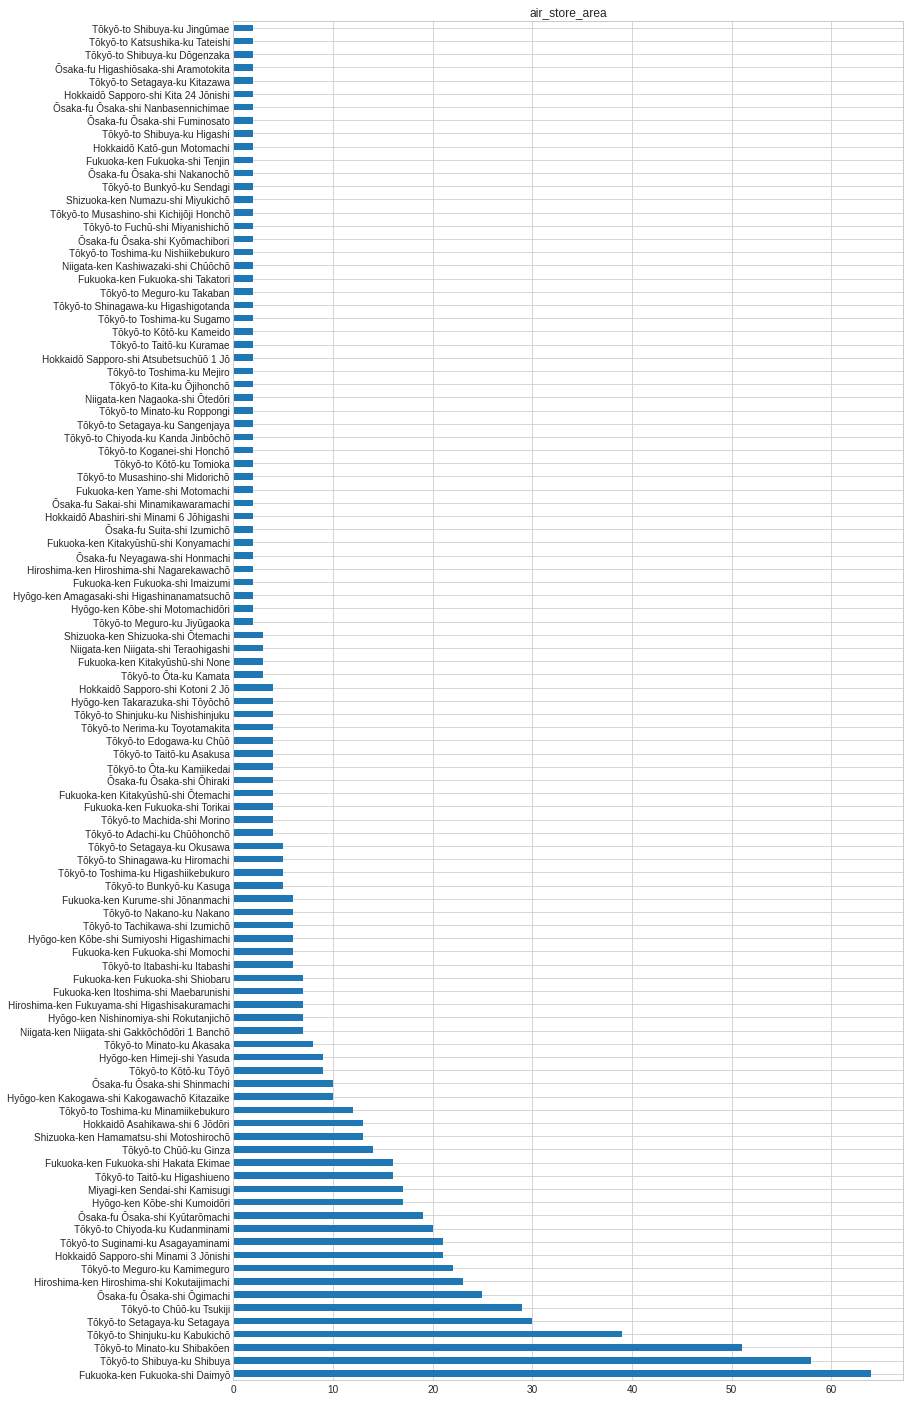

In [85]:
area_sr.plot(kind='barh', figsize=(12, 25))
plt.title("air_store_area")
plt.ylabel('')
# plt.savefig('img/air_store_area.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'air_store_location')

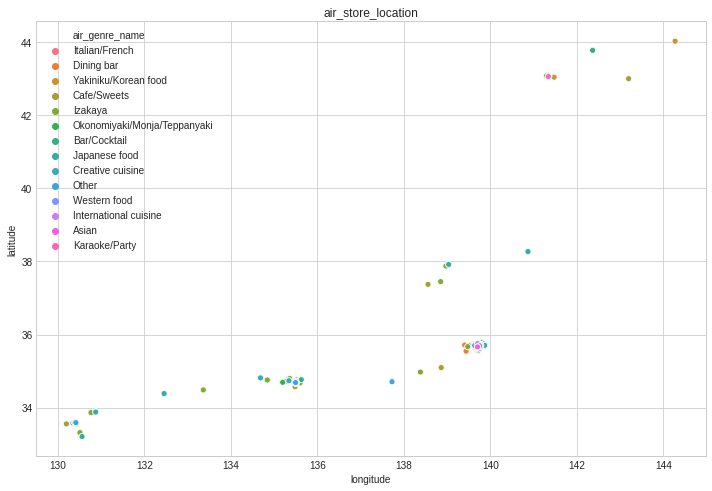

In [86]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', data=info,
                hue='air_genre_name', sizes=1)
plt.title("air_store_location")
# plt.savefig('img/air_store_location.png', dpi=300, bbox_inches='tight')

#### 小结：如上图可见店铺主要分布在日本本洲岛主要的城市中。不同店铺在不同时间的客流分布形态多样，在范围内有数据有一定的周期性。

## 四、特征工程开始
[回到目录](#目录)

### 1.处理时间特征

In [29]:
# 转换格式
visit['visit_date'] = pd.to_datetime(visit['visit_date'])

In [30]:
# 年份
visit['year'] = visit['visit_date'].dt.year
# 月份
visit['month'] = visit['visit_date'].dt.month
# 日期
visit['day'] = visit['visit_date'].dt.day
# 季度
visit['quarter'] = visit['visit_date'].dt.quarter
# 第几周
visit['weekofyear'] = visit['visit_date'].dt.weekofyear
# 第几天
visit['dayofyear'] = visit['visit_date'].dt.dayofyear

In [31]:
# 上旬、中旬、下旬
visit['t_first_tendays'] = 0
visit.loc[visit.day.isin(range(1, 11)), 't_first_tendays'] = 1
visit['t_middle_tendays'] = 0
visit.loc[visit.day.isin(range(11, 21)), 't_middle_tendays'] = 1
visit['t_last_tendays'] = 0
visit.loc[visit.day.isin(range(21, 32)), 't_last_tendays'] = 1

In [32]:
visit.sample(10)

,air_store_id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,t_middle_tendays,t_last_tendays
182016,air_9b6af3db40da4ae2,2016-10-30,26,2016,10,30,4,43,304,0,0,1
250212,air_b5598d12d1b84890,2017-02-05,9,2017,2,5,1,5,36,1,0,0
70541,air_670a0c1c4108bcea,2017-03-14,32,2017,3,14,1,11,73,0,1,0
245481,air_15e6e15c7ea2c162,2017-04-03,12,2017,4,3,2,14,93,1,0,0
241576,air_bc991c51d6613745,2016-11-28,14,2016,11,28,4,48,333,0,0,1
145634,air_c225148c0fcc5c72,2016-01-05,5,2016,1,5,1,1,5,1,0,0
110919,air_10393f12e9069760,2016-10-28,14,2016,10,28,4,43,302,0,0,1
242007,air_5a9a6cbeeb434c08,2016-07-25,11,2016,7,25,3,30,207,0,0,1
123158,air_63a750d8b4b6a976,2016-02-25,1,2016,2,25,1,8,56,0,0,1
98135,air_0728814bd98f7367,2017-02-09,2,2017,2,9,1,6,40,1,0,0


In [33]:
# 合并dates数据表
dates['calendar_date'] = pd.to_datetime(dates['calendar_date'])
data = pd.merge(visit, dates, how='left',
                left_on='visit_date', right_on='calendar_date')

In [34]:
data.drop('calendar_date', axis=1, inplace=True)
data.head()

,air_store_id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,t_middle_tendays,t_last_tendays,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13,1,2,13,0,1,0,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,2016,1,14,1,2,14,0,1,0,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,2016,1,15,1,2,15,0,1,0,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,2016,1,16,1,2,16,0,1,0,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,2016,1,18,1,3,18,0,1,0,Monday,0


In [35]:
# 星期的独热编码化
data['day_of_week'] = data['day_of_week'].str.lower()
week_encode = pd.get_dummies(data['day_of_week'], prefix="w")
week_encode.head()

,w_friday,w_monday,w_saturday,w_sunday,w_thursday,w_tuesday,w_wednesday
0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0


In [36]:
data = data.join(week_encode).drop('day_of_week', axis=1)
data.sample(5)

,air_store_id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,t_middle_tendays,t_last_tendays,holiday_flg,w_friday,w_monday,w_saturday,w_sunday,w_thursday,w_tuesday,w_wednesday
226032,air_8ec47c0f1e2c879e,2016-07-15,31,2016,7,15,3,28,197,0,1,0,0,1,0,0,0,0,0,0
205188,air_d1418d6fd6d634f2,2016-09-08,12,2016,9,8,3,36,252,1,0,0,0,0,0,0,0,1,0,0
42951,air_6411203a47b5ec77,2017-01-27,13,2017,1,27,1,4,27,0,0,1,0,1,0,0,0,0,0,0
182292,air_e053c561f32acc28,2016-10-11,11,2016,10,11,4,41,285,0,1,0,0,0,0,0,0,0,1,0
224279,air_4beac252540f865e,2016-12-23,71,2016,12,23,4,51,358,0,0,1,1,1,0,0,0,0,0,0


### 2.补充前21天客流的时间序列

In [37]:
df1 = data.copy()

In [38]:
data.head()

,air_store_id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,t_middle_tendays,t_last_tendays,holiday_flg,w_friday,w_monday,w_saturday,w_sunday,w_thursday,w_tuesday,w_wednesday
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13,1,2,13,0,1,0,0,0,0,0,0,0,0,1
1,air_ba937bf13d40fb24,2016-01-14,32,2016,1,14,1,2,14,0,1,0,0,0,0,0,0,1,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,2016,1,15,1,2,15,0,1,0,0,1,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,2016,1,16,1,2,16,0,1,0,0,0,0,1,0,0,0,0
4,air_ba937bf13d40fb24,2016-01-18,6,2016,1,18,1,3,18,0,1,0,0,0,1,0,0,0,0,0


In [39]:
df1['visit_date'] = df1['visit_date'] + pd.DateOffset(days=7)

In [40]:
df1 = df1.rename(columns={'visitors': 'lagging' + str(7)})

In [41]:
df1.head()

,air_store_id,visit_date,lagging7,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,t_middle_tendays,t_last_tendays,holiday_flg,w_friday,w_monday,w_saturday,w_sunday,w_thursday,w_tuesday,w_wednesday
0,air_ba937bf13d40fb24,2016-01-20,25,2016,1,13,1,2,13,0,1,0,0,0,0,0,0,0,0,1
1,air_ba937bf13d40fb24,2016-01-21,32,2016,1,14,1,2,14,0,1,0,0,0,0,0,0,1,0,0
2,air_ba937bf13d40fb24,2016-01-22,29,2016,1,15,1,2,15,0,1,0,0,1,0,0,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-23,22,2016,1,16,1,2,16,0,1,0,0,0,0,1,0,0,0,0
4,air_ba937bf13d40fb24,2016-01-25,6,2016,1,18,1,3,18,0,1,0,0,0,1,0,0,0,0,0


In [42]:
df2 = pd.merge(data,
               df1[['air_store_id', 'visit_date', 'lagging' + str(7)]],
               on=['air_store_id', 'visit_date'],
               how='left')

In [43]:
def create_lagging(df, df_original, i):
    df1 = df_original.copy()
    df1['visit_date'] = df1['visit_date'] + pd.DateOffset(
        days=i)
    df1 = df1.rename(columns={'visitors': 'lagging' + str(i)})
    df2 = pd.merge(df,
                   df1[['air_store_id', 'visit_date', 'lagging' + str(i)]],
                   on=['air_store_id', 'visit_date'],
                   how='left')
    return df2

In [44]:
data1 = create_lagging(data, data, 1)

In [45]:
# 最新的店铺只有20天的数据
lagging = 21
for i in range(2, lagging+1):
    data1 = create_lagging(data1, data, i)

In [46]:
data1.head(25)

,air_store_id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,...,lagging12,lagging13,lagging14,lagging15,lagging16,lagging17,lagging18,lagging19,lagging20,lagging21
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13,1,2,13,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,2016,1,14,1,2,14,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,2016,1,15,1,2,15,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,2016,1,16,1,2,16,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,2016,1,18,1,3,18,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,air_ba937bf13d40fb24,2016-01-19,9,2016,1,19,1,3,19,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,air_ba937bf13d40fb24,2016-01-20,31,2016,1,20,1,3,20,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,air_ba937bf13d40fb24,2016-01-21,21,2016,1,21,1,3,21,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,air_ba937bf13d40fb24,2016-01-22,18,2016,1,22,1,3,22,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,air_ba937bf13d40fb24,2016-01-23,26,2016,1,23,1,3,23,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data1.columns

Index(['air_store_id', 'visit_date', 'visitors', 'year', 'month', 'day',
       'quarter', 'weekofyear', 'dayofyear', 't_first_tendays',
       't_middle_tendays', 't_last_tendays', 'holiday_flg', 'w_friday',
       'w_monday', 'w_saturday', 'w_sunday', 'w_thursday', 'w_tuesday',
       'w_wednesday', 'lagging1', 'lagging2', 'lagging3', 'lagging4',
       'lagging5', 'lagging6', 'lagging7', 'lagging8', 'lagging9', 'lagging10',
       'lagging11', 'lagging12', 'lagging13', 'lagging14', 'lagging15',
       'lagging16', 'lagging17', 'lagging18', 'lagging19', 'lagging20',
       'lagging21'],
      dtype='object')

### 3.处理店铺类型特征

In [48]:
# 店铺ID转换成连续数值
data1['store_id'] = data1['air_store_id'].factorize()[0]

In [50]:
data1['store_id'].value_counts()

527    477
702    476
675    476
596    476
393    475
      ... 
39      51
358     47
523     41
406     40
525     20
Name: store_id, Length: 829, dtype: int64

In [52]:
# 合并info数据表
data = pd.merge(data1, info, how='left', on='air_store_id')
data.sample(5)

,air_store_id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,...,lagging17,lagging18,lagging19,lagging20,lagging21,store_id,air_genre_name,air_area_name,latitude,longitude
119672,air_4579cb0669fd411b,2017-02-14,27,2017,2,14,1,7,45,0,...,65.0,19.0,13.0,18.0,21.0,394,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813
94020,air_f1f9027d4fa8f653,2016-09-21,7,2016,9,21,3,38,265,0,...,NaN,15.0,27.0,32.0,50.0,311,Izakaya,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
18816,air_b4f32bcc399da2b9,2016-11-01,4,2016,11,1,4,44,306,1,...,70.0,63.0,17.0,28.0,9.0,65,Dining bar,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018
44748,air_88c8e34baa79217b,2016-12-14,34,2016,12,14,4,50,349,0,...,NaN,23.0,34.0,29.0,22.0,146,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
82902,air_2bffb19a24d11729,2016-07-23,27,2016,7,23,3,29,205,0,...,21.0,11.0,12.0,8.0,29.0,272,Yakiniku/Korean food,Ōsaka-fu Ōsaka-shi Ōgimachi,34.705362,135.510025


In [53]:
# 简化名称，统一小写
data = data.rename(columns={'air_store_id': 'id',
                            'air_genre_name': 'genre', 'air_area_name': 'area'})
data['genre'] = data['genre'].str.lower()
data['area'] = data['area'].str.lower()

In [54]:
# 店铺类型独热编码化
genre_encode = pd.get_dummies(data['genre'], prefix="g")
data = data.join(genre_encode).drop('genre', axis=1)
data.sample(5)

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,...,g_dining bar,g_international cuisine,g_italian/french,g_izakaya,g_japanese food,g_karaoke/party,g_okonomiyaki/monja/teppanyaki,g_other,g_western food,g_yakiniku/korean food
137834,air_f180301886c21375,2017-03-16,14,2017,3,16,1,11,75,0,...,0,0,0,0,0,0,0,0,0,1
12206,air_f8233ad00755c35c,2017-01-10,19,2017,1,10,1,2,10,1,...,0,0,1,0,0,0,0,0,0,0
219771,air_dfad598ff642dab7,2016-08-27,28,2016,8,27,3,34,240,0,...,0,0,0,0,0,0,0,0,0,1
78933,air_6e3fd96320d24324,2016-04-27,29,2016,4,27,2,17,118,0,...,0,0,0,1,0,0,0,0,0,0
51023,air_1707a3f18bb0da07,2017-02-16,25,2017,2,16,1,7,47,0,...,0,0,0,1,0,0,0,0,0,0


### 4.处理位置特征

In [55]:
# 特殊字母处理
data['area'] = data['area'].str.replace('ō', 'o')
data['area'] = data['area'].str.replace('ū', 'u')
# 位置结尾有-to -ku -shi -fu -ken
data['area'] = data['area'].str.replace('-to', '')
data['area'] = data['area'].str.replace('-ku', '')
data['area'] = data['area'].str.replace('-shi', '')
data['area'] = data['area'].str.replace('-fu', '')
data['area'] = data['area'].str.replace('-ken', '')

In [56]:
# 提取每个店铺所在大区、市、县
data['district'] = data['area'].str.split(' ').str[0]
data['city'] = data['area'].str.split(' ').str[1]
data['county'] = data['area'].str.split(' ').str[2]

In [57]:
data[['district', 'city', 'county']].sample(10)

,district,city,county
25214,hiroshima,hiroshima,kokutaijimachi
120751,hiroshima,hiroshima,kokutaijimachi
122131,tokyo,shibuya,shibuya
57089,fukuoka,fukuoka,daimyo
201466,fukuoka,fukuoka,daimyo
4184,fukuoka,fukuoka,daimyo
246024,tokyo,taito,higashiueno
217098,tokyo,taito,kuramae
70514,osaka,osaka,kyutaromachi
131682,hyogo,kobe,kumoidori


In [58]:
# 大区特征独热编码化
district_encode = pd.get_dummies(data['district'], prefix="d")
data = data.join(district_encode)
data.sample(5)

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,...,county,d_fukuoka,d_hiroshima,d_hokkaido,d_hyogo,d_miyagi,d_niigata,d_osaka,d_shizuoka,d_tokyo
30405,air_0a74a5408a0b8642,2017-01-11,32,2017,1,11,1,2,11,0,...,minami,0,0,1,0,0,0,0,0,0
25126,air_4d21676ed11f0bac,2016-09-06,44,2016,9,6,3,36,250,1,...,kokutaijimachi,0,1,0,0,0,0,0,0,0
43784,air_eca4a5a191e8d993,2017-02-15,43,2017,2,15,1,7,46,0,...,kamisugi,0,0,0,0,1,0,0,0,0
189290,air_310e467e6e625004,2017-04-13,10,2017,4,13,2,15,103,0,...,tsukiji,0,0,0,0,0,0,0,0,1
14465,air_627cabe2fe53f33f,2016-07-25,4,2016,7,25,3,30,207,0,...,kumoidori,0,0,0,1,0,0,0,0,0


In [59]:
# 保存数据，准备加上天气数据
data.to_csv('data_set/data_processing.csv', index=False)

## 五、加入天气特征
[回到目录](#目录)

### 1.不同地区天气搜索对应的文件

In [60]:
data = pd.read_csv('data_set/data_processing.csv')
data['visit_date'] = pd.to_datetime(data['visit_date'])

In [61]:
print(data['area'].unique().shape, data['district'].unique().shape)

(103,) (9,)


#### 经过对店铺所在103个地方的是否有对应的天气数据文件进行逐条搜索，发现天所数据分为三种类型：

- 有详细天气信息，缺失值部分可以用0来填充，有34个地方，称为一类地方：

'fukuoka fukuoka daimyo',
'fukuoka fukuoka hakata ekimae',
'fukuoka fukuoka imaizumi',
'fukuoka fukuoka momochi',
'fukuoka fukuoka shiobaru',
'fukuoka fukuoka takatori',
'fukuoka fukuoka tenjin',
'fukuoka fukuoka torikai',
'hiroshima fukuyama higashisakuramachi',
'hiroshima hiroshima kokutaijimachi',
'hiroshima hiroshima nagarekawacho',
'hokkaido abashiri minami 6 johigashi',
'hokkaido asahikawa 6 jodori',
'hokkaido sapporo atsubetsuchuo 1 jo',
'hokkaido sapporo kita 24 jonishi',
'hokkaido sapporo kotoni 2 jo',
'hokkaido sapporo minami 3 jonishi',
'hyogo himeji yasuda',
'hyogo kobe kumoidori',
'hyogo kobe motomachidori',
'hyogo kobe sumiyoshi higashimachi',
'miyagi sendai kamisugi',
'niigata niigata gakkochodori 1 bancho',
'niigata niigata teraohigashi',
'osaka osaka fuminosato',
'osaka osaka kyomachibori',
'osaka osaka kyutaromachi',
'osaka osaka nakanocho',
'osaka osaka nanbasennichimae',
'osaka osaka ogimachi', 
'osaka osaka ohiraki',
'osaka osaka shinmachi',
'shizuoka hamamatsu motoshirocho',
'shizuoka shizuoka otemachi',

- 有部分天气信息，有缺失，但缺失值可以全部用0填充，如：太阳辐射、最深降雪、总降雪、云层量这四列，有7个地方，称为二类地方：

'fukuoka kurume jonanmachi',
'niigata kashiwazaki chuocho',
'niigata nagaoka otedori',
'osaka sakai minamikawaramachi',
'tokyo edogawa chuo',
'tokyo fuchu miyanishicho',
'tokyo nerima toyotamakita',

- 找不到对应的天气信息，或天气数据只有一两列有数据，无法填充的，如：风速、气压、湿度相关列，有62个地方，主要集中在东京大区：

'fukuoka itoshima maebarunishi',
'fukuoka kitakyushu konyamachi',
'fukuoka kitakyushu none',
'fukuoka kitakyushu otemachi',
'fukuoka yame motomachi',
'hokkaido kato-gun motomachi',
'hyogo amagasaki higashinanamatsucho',
'hyogo kakogawa kakogawacho kitazaike',
'hyogo nishinomiya rokutanjicho',
'hyogo takarazuka toyocho',
'osaka higashiosaka aramotokita',
'osaka neyagawa honmachi',
'osaka suita izumicho',
'shizuoka numazu miyukicho',
'tokyo adachi chuohoncho',
'tokyo bunkyo kasuga', 
'tokyo bunkyo sendagi',
'tokyo chiyoda kanda jinbocho',
'tokyo chiyoda kudanminami',
'tokyo chuo ginza',
'tokyo chuo tsukiji'
'tokyo itabashi itabashi',
'tokyo katsushika tateishi',
'tokyo kita ojihoncho',
'tokyo koganei honcho',
'tokyo koto kameido',
'tokyo koto tomioka',
'tokyo koto toyo',
'tokyo machida morino',
'tokyo meguro jiyugaoka',
'tokyo meguro kamimeguro',
'tokyo meguro takaban',
'tokyo minato akasaka',
'tokyo minato roppongi',
'tokyo minato shibakoen',
'tokyo musashino kichijoji honcho',
'tokyo musashino midoricho',
'tokyo nakano nakano',
'tokyo ota kamata',
'tokyo ota kamiikedai',
'tokyo setagaya kitazawa'
'tokyo setagaya okusawa',
'tokyo setagaya sangenjaya',
'tokyo setagaya setagaya',
'tokyo shibuya dogenzaka',
'tokyo shibuya higashi',
'tokyo shibuya jingumae',
'tokyo shibuya shibuya',
'tokyo shinagawa higashigotanda',
'tokyo shinagawa hiromachi',
'tokyo shinjuku kabukicho',
'tokyo shinjuku nishishinjuku',
'tokyo suginami asagayaminami',
'tokyo tachikawa izumicho',
'tokyo taito asakusa',
'tokyo taito higashiueno',
'tokyo taito kuramae',
'tokyo toshima higashiikebukuro',
'tokyo toshima mejiro',
'tokyo toshima minamiikebukuro',
'tokyo toshima nishiikebukuro',
'tokyo toshima sugamo',

#### 对于1663个天气数据文件，手动删除了体积小于20K的文件，因为这些只有一两列是有数据的；体积大于30K的文件，通常有全部的天气信息；20-29K的文件，通常有大部分天气信息。同时也手动删除了9个大区以外的天气文件，剩下323个可用文件。

In [62]:
fukuoka_fukuoka = pd.read_csv(
    'Weather/fukuoka__fukuoka-kana__fukuoka.csv', index_col='calendar_date')
hiroshima_fukuyama = pd.read_csv(
    'Weather/hiroshima__fukuyama-kana__fukuyama.csv', index_col='calendar_date')
hiroshima_hiroshima = pd.read_csv(
    'Weather/hiroshima__hiroshima-kana__hiroshima.csv', index_col='calendar_date')
hokkaido_abashiri = pd.read_csv(
    'Weather/hokkaido_okhotsk__abashiri-kana__abashiri.csv', index_col='calendar_date')
hokkaido_asahikawa = pd.read_csv(
    'Weather/hokkaido_kamikawa__asahikawa-kana__asahikawa.csv', index_col='calendar_date')
hokkaido_sapporo = pd.read_csv(
    'Weather/hokkaido_ishikari__sapporo-katakana__satporo.csv', index_col='calendar_date')
hyogo_himeji = pd.read_csv(
    'Weather/hyogo__himeji-kana__gimpe.csv', index_col='calendar_date')
hyogo_kobe = pd.read_csv(
    'Weather/hyogo__kobe-kana__koube.csv', index_col='calendar_date')
niigata_niigata = pd.read_csv(
    'Weather/niigata__niigata-kana__niigata.csv', index_col='calendar_date')
osaka_osaka = pd.read_csv(
    'Weather/osaka__osaka-kana__osaka.csv', index_col='calendar_date')
shizuoka_hamamatsu = pd.read_csv(
    'Weather/shizuoka__hamamatsu-kana__hamamatsu.csv', index_col='calendar_date')
shizuoka_shizuoka = pd.read_csv(
    'Weather/shizuoka__shizuoka-kana__shizuoka.csv', index_col='calendar_date')

In [63]:
fukuoka_kurume = pd.read_csv(
    'Weather/fukuoka__kurume-kana__kurume.csv', index_col='calendar_date')
niigata_kashiwazaki = pd.read_csv(
    'Weather/niigata__kashiwazaki-kana__kashiwazaki.csv', index_col='calendar_date')
niigata_nagaoka = pd.read_csv(
    'Weather/niigata__nagaoka-kana__nagaoka.csv', index_col='calendar_date')
osaka_sakai = pd.read_csv(
    'Weather/osaka__sakai-kana__sakai.csv', index_col='calendar_date')
tokyo_edogawa = pd.read_csv(
    'Weather/tokyo__edogawa-seaside-kana__edgawawinkai.csv', index_col='calendar_date')
tokyo_fuchu = pd.read_csv(
    'Weather/tokyo__fuchu-kana__fuku.csv', index_col='calendar_date')
tokyo_nerima = pd.read_csv(
    'Weather/tokyo__nerima-kana__nerima.csv', index_col='calendar_date')

### 2.合并九个地区的天气数据文件

In [64]:
import os
weather_all = os.listdir('./Weather')

# 定义合并同一大区天气数据文件的函数


def concat_district_weather(district):
    # 找到大区的文件名
    district_weather = []
    for file in weather_all:
        if file.startswith(district):
            district_weather.append(file)
    print("{} weather's files: ".format(district), len(district_weather))
#     print(district_weather)

    # 读取文件到DF，并存放到列表中
    df_list = []
    for file in district_weather:
        df = pd.read_csv('./Weather/{}'.format(file))
        df_list.append(df)

    # 合并大区天气数据行
    district_df = pd.concat(df_list, axis=0)
    # 转为时期格式，方便之后与主数据文件合并
    district_df['calendar_date'] = pd.to_datetime(district_df['calendar_date'])
    # 同一天，不同表的同一个位置按平均值计算天气数据，得到地区各项天气指标的平均值
    district_df = district_df.groupby('calendar_date').mean()
    # 用0填充太阳辐射、最深降雪、总降雪三列的缺失值
    district_df.fillna(0, inplace=True)
#     print(district_df.info())
    print('**********{} district concat complete**********'.format(district))
    return district_df

In [65]:
data['district'].unique()

array(['tokyo', 'osaka', 'hokkaido', 'shizuoka', 'fukuoka', 'hiroshima',
       'hyogo', 'niigata', 'miyagi'], dtype=object)

In [66]:
w_tokyo = concat_district_weather('tokyo')

tokyo weather's files:  18
**********tokyo district concat complete**********


In [67]:
w_osaka = concat_district_weather('osaka')

osaka weather's files:  9
**********osaka district concat complete**********


In [68]:
w_hokkaido = concat_district_weather('hokkaido')

hokkaido weather's files:  173
**********hokkaido district concat complete**********


In [69]:
w_shizuoka = concat_district_weather('shizuoka')

shizuoka weather's files:  19
**********shizuoka district concat complete**********


In [70]:
w_fukuoka = concat_district_weather('fukuoka')

fukuoka weather's files:  14
**********fukuoka district concat complete**********


In [71]:
w_hiroshima = concat_district_weather('hiroshima')

hiroshima weather's files:  19
**********hiroshima district concat complete**********


In [72]:
w_hyogo = concat_district_weather('hyogo')

hyogo weather's files:  20
**********hyogo district concat complete**********


In [73]:
w_niigata = concat_district_weather('niigata')

niigata weather's files:  29
**********niigata district concat complete**********


In [74]:
w_miyagi = concat_district_weather('miyagi')

miyagi weather's files:  22
**********miyagi district concat complete**********


In [75]:
district_weather = [w_tokyo, w_osaka, w_hokkaido, w_shizuoka,
                    w_fukuoka, w_hiroshima, w_hyogo, w_niigata, w_miyagi]

### 3.用大地区的天气数据填充一类地方的缺失数据

#### 填充降雪、积水、辐射、云层的缺失数据

In [76]:
places_1 = [fukuoka_fukuoka, hiroshima_fukuyama, hiroshima_hiroshima, hokkaido_abashiri, hokkaido_asahikawa,
            hokkaido_sapporo, hyogo_himeji, hyogo_kobe, niigata_niigata, osaka_osaka, shizuoka_hamamatsu, shizuoka_shizuoka, ]

In [77]:
fukuoka_fukuoka['precipitation'] = fukuoka_fukuoka['precipitation'].fillna(
    w_fukuoka['precipitation'])
fukuoka_fukuoka['deepest_snowfall'] = fukuoka_fukuoka['deepest_snowfall'].fillna(
    w_fukuoka['deepest_snowfall'])
fukuoka_fukuoka['total_snowfall'] = fukuoka_fukuoka['total_snowfall'].fillna(
    w_fukuoka['total_snowfall'])
fukuoka_fukuoka['solar_radiation'] = fukuoka_fukuoka['solar_radiation'].fillna(
    w_fukuoka['solar_radiation'])
fukuoka_fukuoka['cloud_cover'] = fukuoka_fukuoka['cloud_cover'].fillna(
    w_fukuoka['cloud_cover'])

hiroshima_fukuyama['precipitation'] = hiroshima_fukuyama['precipitation'].fillna(
    w_hiroshima['precipitation'])
hiroshima_fukuyama['deepest_snowfall'] = hiroshima_fukuyama['deepest_snowfall'].fillna(
    w_hiroshima['deepest_snowfall'])
hiroshima_fukuyama['total_snowfall'] = hiroshima_fukuyama['total_snowfall'].fillna(
    w_hiroshima['total_snowfall'])
hiroshima_fukuyama['solar_radiation'] = hiroshima_fukuyama['solar_radiation'].fillna(
    w_hiroshima['solar_radiation'])
hiroshima_fukuyama['cloud_cover'] = hiroshima_fukuyama['cloud_cover'].fillna(
    w_hiroshima['cloud_cover'])

hiroshima_hiroshima['precipitation'] = hiroshima_hiroshima['precipitation'].fillna(
    w_hiroshima['precipitation'])
hiroshima_hiroshima['deepest_snowfall'] = hiroshima_hiroshima['deepest_snowfall'].fillna(
    w_hiroshima['deepest_snowfall'])
hiroshima_hiroshima['total_snowfall'] = hiroshima_hiroshima['total_snowfall'].fillna(
    w_hiroshima['total_snowfall'])
hiroshima_hiroshima['solar_radiation'] = hiroshima_hiroshima['solar_radiation'].fillna(
    w_hiroshima['solar_radiation'])
hiroshima_hiroshima['cloud_cover'] = hiroshima_hiroshima['cloud_cover'].fillna(
    w_hiroshima['cloud_cover'])

hokkaido_abashiri['precipitation'] = hokkaido_abashiri['precipitation'].fillna(
    w_hokkaido['precipitation'])
hokkaido_abashiri['deepest_snowfall'] = hokkaido_abashiri['deepest_snowfall'].fillna(
    w_hokkaido['deepest_snowfall'])
hokkaido_abashiri['total_snowfall'] = hokkaido_abashiri['total_snowfall'].fillna(
    w_hokkaido['total_snowfall'])
hokkaido_abashiri['solar_radiation'] = hokkaido_abashiri['solar_radiation'].fillna(
    w_hokkaido['solar_radiation'])
hokkaido_abashiri['cloud_cover'] = hokkaido_abashiri['cloud_cover'].fillna(
    w_hokkaido['cloud_cover'])

hokkaido_asahikawa['precipitation'] = hokkaido_asahikawa['precipitation'].fillna(
    w_hokkaido['precipitation'])
hokkaido_asahikawa['deepest_snowfall'] = hokkaido_asahikawa['deepest_snowfall'].fillna(
    w_hokkaido['deepest_snowfall'])
hokkaido_asahikawa['total_snowfall'] = hokkaido_asahikawa['total_snowfall'].fillna(
    w_hokkaido['total_snowfall'])
hokkaido_asahikawa['solar_radiation'] = hokkaido_asahikawa['solar_radiation'].fillna(
    w_hokkaido['solar_radiation'])
hokkaido_asahikawa['cloud_cover'] = hokkaido_asahikawa['cloud_cover'].fillna(
    w_hokkaido['cloud_cover'])

hokkaido_sapporo['precipitation'] = hokkaido_sapporo['precipitation'].fillna(
    w_hokkaido['precipitation'])
hokkaido_sapporo['deepest_snowfall'] = hokkaido_sapporo['deepest_snowfall'].fillna(
    w_hokkaido['deepest_snowfall'])
hokkaido_sapporo['total_snowfall'] = hokkaido_sapporo['total_snowfall'].fillna(
    w_hokkaido['total_snowfall'])
hokkaido_sapporo['solar_radiation'] = hokkaido_sapporo['solar_radiation'].fillna(
    w_hokkaido['solar_radiation'])
hokkaido_sapporo['cloud_cover'] = hokkaido_sapporo['cloud_cover'].fillna(
    w_hokkaido['cloud_cover'])

hyogo_himeji['precipitation'] = hyogo_himeji['precipitation'].fillna(
    w_hyogo['precipitation'])
hyogo_himeji['deepest_snowfall'] = hyogo_himeji['deepest_snowfall'].fillna(
    w_hyogo['deepest_snowfall'])
hyogo_himeji['total_snowfall'] = hyogo_himeji['total_snowfall'].fillna(
    w_hyogo['total_snowfall'])
hyogo_himeji['solar_radiation'] = hyogo_himeji['solar_radiation'].fillna(
    w_hyogo['solar_radiation'])
hyogo_himeji['cloud_cover'] = hyogo_himeji['cloud_cover'].fillna(
    w_hyogo['cloud_cover'])

hyogo_kobe['precipitation'] = hyogo_kobe['precipitation'].fillna(
    w_hyogo['precipitation'])
hyogo_kobe['deepest_snowfall'] = hyogo_kobe['deepest_snowfall'].fillna(
    w_hyogo['deepest_snowfall'])
hyogo_kobe['total_snowfall'] = hyogo_kobe['total_snowfall'].fillna(
    w_hyogo['total_snowfall'])
hyogo_kobe['solar_radiation'] = hyogo_kobe['solar_radiation'].fillna(
    w_hyogo['solar_radiation'])
hyogo_kobe['cloud_cover'] = hyogo_kobe['cloud_cover'].fillna(
    w_hyogo['cloud_cover'])

niigata_niigata['precipitation'] = niigata_niigata['precipitation'].fillna(
    w_niigata['precipitation'])
niigata_niigata['deepest_snowfall'] = niigata_niigata['deepest_snowfall'].fillna(
    w_niigata['deepest_snowfall'])
niigata_niigata['total_snowfall'] = niigata_niigata['total_snowfall'].fillna(
    w_niigata['total_snowfall'])
niigata_niigata['solar_radiation'] = niigata_niigata['solar_radiation'].fillna(
    w_niigata['solar_radiation'])
niigata_niigata['cloud_cover'] = niigata_niigata['cloud_cover'].fillna(
    w_niigata['cloud_cover'])

osaka_osaka['precipitation'] = osaka_osaka['precipitation'].fillna(
    w_osaka['precipitation'])
osaka_osaka['deepest_snowfall'] = osaka_osaka['deepest_snowfall'].fillna(
    w_osaka['deepest_snowfall'])
osaka_osaka['total_snowfall'] = osaka_osaka['total_snowfall'].fillna(
    w_osaka['total_snowfall'])
osaka_osaka['solar_radiation'] = osaka_osaka['solar_radiation'].fillna(
    w_osaka['solar_radiation'])
osaka_osaka['cloud_cover'] = osaka_osaka['cloud_cover'].fillna(
    w_osaka['cloud_cover'])

shizuoka_hamamatsu['precipitation'] = shizuoka_hamamatsu['precipitation'].fillna(
    w_shizuoka['precipitation'])
shizuoka_hamamatsu['deepest_snowfall'] = shizuoka_hamamatsu['deepest_snowfall'].fillna(
    w_shizuoka['deepest_snowfall'])
shizuoka_hamamatsu['total_snowfall'] = shizuoka_hamamatsu['total_snowfall'].fillna(
    w_shizuoka['total_snowfall'])
shizuoka_hamamatsu['solar_radiation'] = shizuoka_hamamatsu['solar_radiation'].fillna(
    w_shizuoka['solar_radiation'])
shizuoka_hamamatsu['cloud_cover'] = shizuoka_hamamatsu['cloud_cover'].fillna(
    w_shizuoka['cloud_cover'])

shizuoka_shizuoka['precipitation'] = shizuoka_shizuoka['precipitation'].fillna(
    w_shizuoka['precipitation'])
shizuoka_shizuoka['deepest_snowfall'] = shizuoka_shizuoka['deepest_snowfall'].fillna(
    w_shizuoka['deepest_snowfall'])
shizuoka_shizuoka['total_snowfall'] = shizuoka_shizuoka['total_snowfall'].fillna(
    w_shizuoka['total_snowfall'])
shizuoka_shizuoka['solar_radiation'] = shizuoka_shizuoka['solar_radiation'].fillna(
    w_shizuoka['solar_radiation'])
shizuoka_shizuoka['cloud_cover'] = shizuoka_shizuoka['cloud_cover'].fillna(
    w_shizuoka['cloud_cover'])

#### 用前一天值填充少量风速、温度、气压等少量数据

In [78]:
for df in places_1:
    df = df.fillna(method='bfill')

### 4.用大区的天气数据填充二类地方的大量缺失数据

In [79]:
places_2 = [fukuoka_kurume, niigata_kashiwazaki, niigata_nagaoka,
            osaka_sakai, tokyo_edogawa, tokyo_fuchu, tokyo_nerima, ]

In [80]:
fukuoka_kurume['solar_radiation'] = fukuoka_kurume['solar_radiation'].fillna(
    w_fukuoka['solar_radiation'])
fukuoka_kurume['deepest_snowfall'] = fukuoka_kurume['deepest_snowfall'].fillna(
    w_fukuoka['deepest_snowfall'])
fukuoka_kurume['total_snowfall'] = fukuoka_kurume['total_snowfall'].fillna(
    w_fukuoka['total_snowfall'])
fukuoka_kurume['avg_vapor_pressure'] = fukuoka_kurume['avg_vapor_pressure'].fillna(
    w_fukuoka['avg_vapor_pressure'])
fukuoka_kurume['avg_local_pressure'] = fukuoka_kurume['avg_local_pressure'].fillna(
    w_fukuoka['avg_local_pressure'])
fukuoka_kurume['avg_humidity'] = fukuoka_kurume['avg_humidity'].fillna(
    w_fukuoka['avg_humidity'])
fukuoka_kurume['avg_sea_pressure'] = fukuoka_kurume['avg_sea_pressure'].fillna(
    w_fukuoka['avg_sea_pressure'])
fukuoka_kurume['cloud_cover'] = fukuoka_kurume['cloud_cover'].fillna(
    w_fukuoka['cloud_cover'])

niigata_kashiwazaki['solar_radiation'] = niigata_kashiwazaki['solar_radiation'].fillna(
    w_niigata['solar_radiation'])
niigata_kashiwazaki['deepest_snowfall'] = niigata_kashiwazaki['deepest_snowfall'].fillna(
    w_niigata['deepest_snowfall'])
niigata_kashiwazaki['total_snowfall'] = niigata_kashiwazaki['total_snowfall'].fillna(
    w_niigata['total_snowfall'])
niigata_kashiwazaki['avg_vapor_pressure'] = niigata_kashiwazaki['avg_vapor_pressure'].fillna(
    w_niigata['avg_vapor_pressure'])
niigata_kashiwazaki['avg_local_pressure'] = niigata_kashiwazaki['avg_local_pressure'].fillna(
    w_niigata['avg_local_pressure'])
niigata_kashiwazaki['avg_humidity'] = niigata_kashiwazaki['avg_humidity'].fillna(
    w_niigata['avg_humidity'])
niigata_kashiwazaki['avg_sea_pressure'] = niigata_kashiwazaki['avg_sea_pressure'].fillna(
    w_niigata['avg_sea_pressure'])
niigata_kashiwazaki['cloud_cover'] = niigata_kashiwazaki['cloud_cover'].fillna(
    w_niigata['cloud_cover'])

niigata_nagaoka['solar_radiation'] = niigata_nagaoka['solar_radiation'].fillna(
    w_niigata['solar_radiation'])
niigata_nagaoka['deepest_snowfall'] = niigata_nagaoka['deepest_snowfall'].fillna(
    w_niigata['deepest_snowfall'])
niigata_nagaoka['total_snowfall'] = niigata_nagaoka['total_snowfall'].fillna(
    w_niigata['total_snowfall'])
niigata_nagaoka['avg_vapor_pressure'] = niigata_nagaoka['avg_vapor_pressure'].fillna(
    w_niigata['avg_vapor_pressure'])
niigata_nagaoka['avg_local_pressure'] = niigata_nagaoka['avg_local_pressure'].fillna(
    w_niigata['avg_local_pressure'])
niigata_nagaoka['avg_humidity'] = niigata_nagaoka['avg_humidity'].fillna(
    w_niigata['avg_humidity'])
niigata_nagaoka['avg_sea_pressure'] = niigata_nagaoka['avg_sea_pressure'].fillna(
    w_niigata['avg_sea_pressure'])
niigata_nagaoka['cloud_cover'] = niigata_nagaoka['cloud_cover'].fillna(
    w_niigata['cloud_cover'])

osaka_sakai['solar_radiation'] = osaka_sakai['solar_radiation'].fillna(
    w_osaka['solar_radiation'])
osaka_sakai['deepest_snowfall'] = osaka_sakai['deepest_snowfall'].fillna(
    w_osaka['deepest_snowfall'])
osaka_sakai['total_snowfall'] = osaka_sakai['total_snowfall'].fillna(
    w_osaka['total_snowfall'])
osaka_sakai['avg_vapor_pressure'] = osaka_sakai['avg_vapor_pressure'].fillna(
    w_osaka['avg_vapor_pressure'])
osaka_sakai['avg_local_pressure'] = osaka_sakai['avg_local_pressure'].fillna(
    w_osaka['avg_local_pressure'])
osaka_sakai['avg_humidity'] = osaka_sakai['avg_humidity'].fillna(
    w_osaka['avg_humidity'])
osaka_sakai['avg_sea_pressure'] = osaka_sakai['avg_sea_pressure'].fillna(
    w_osaka['avg_sea_pressure'])
osaka_sakai['cloud_cover'] = osaka_sakai['cloud_cover'].fillna(
    w_osaka['cloud_cover'])

tokyo_edogawa['solar_radiation'] = tokyo_edogawa['solar_radiation'].fillna(
    w_tokyo['solar_radiation'])
tokyo_edogawa['deepest_snowfall'] = tokyo_edogawa['deepest_snowfall'].fillna(
    w_tokyo['deepest_snowfall'])
tokyo_edogawa['total_snowfall'] = tokyo_edogawa['total_snowfall'].fillna(
    w_tokyo['total_snowfall'])
tokyo_edogawa['avg_vapor_pressure'] = tokyo_edogawa['avg_vapor_pressure'].fillna(
    w_tokyo['avg_vapor_pressure'])
tokyo_edogawa['avg_local_pressure'] = tokyo_edogawa['avg_local_pressure'].fillna(
    w_tokyo['avg_local_pressure'])
tokyo_edogawa['avg_humidity'] = tokyo_edogawa['avg_humidity'].fillna(
    w_tokyo['avg_humidity'])
tokyo_edogawa['avg_sea_pressure'] = tokyo_edogawa['avg_sea_pressure'].fillna(
    w_tokyo['avg_sea_pressure'])
tokyo_edogawa['cloud_cover'] = tokyo_edogawa['cloud_cover'].fillna(
    w_tokyo['cloud_cover'])

tokyo_fuchu['solar_radiation'] = tokyo_fuchu['solar_radiation'].fillna(
    w_tokyo['solar_radiation'])
tokyo_fuchu['deepest_snowfall'] = tokyo_fuchu['deepest_snowfall'].fillna(
    w_tokyo['deepest_snowfall'])
tokyo_fuchu['total_snowfall'] = tokyo_fuchu['total_snowfall'].fillna(
    w_tokyo['total_snowfall'])
tokyo_fuchu['avg_vapor_pressure'] = tokyo_fuchu['avg_vapor_pressure'].fillna(
    w_tokyo['avg_vapor_pressure'])
tokyo_fuchu['avg_local_pressure'] = tokyo_fuchu['avg_local_pressure'].fillna(
    w_tokyo['avg_local_pressure'])
tokyo_fuchu['avg_humidity'] = tokyo_fuchu['avg_humidity'].fillna(
    w_tokyo['avg_humidity'])
tokyo_fuchu['avg_sea_pressure'] = tokyo_fuchu['avg_sea_pressure'].fillna(
    w_tokyo['avg_sea_pressure'])
tokyo_fuchu['cloud_cover'] = tokyo_fuchu['cloud_cover'].fillna(
    w_tokyo['cloud_cover'])

tokyo_nerima['solar_radiation'] = tokyo_nerima['solar_radiation'].fillna(
    w_tokyo['solar_radiation'])
tokyo_nerima['deepest_snowfall'] = tokyo_nerima['deepest_snowfall'].fillna(
    w_tokyo['deepest_snowfall'])
tokyo_nerima['total_snowfall'] = tokyo_nerima['total_snowfall'].fillna(
    w_tokyo['total_snowfall'])
tokyo_nerima['avg_vapor_pressure'] = tokyo_nerima['avg_vapor_pressure'].fillna(
    w_tokyo['avg_vapor_pressure'])
tokyo_nerima['avg_local_pressure'] = tokyo_nerima['avg_local_pressure'].fillna(
    w_tokyo['avg_local_pressure'])
tokyo_nerima['avg_humidity'] = tokyo_nerima['avg_humidity'].fillna(
    w_tokyo['avg_humidity'])
tokyo_nerima['avg_sea_pressure'] = tokyo_nerima['avg_sea_pressure'].fillna(
    w_tokyo['avg_sea_pressure'])
tokyo_nerima['cloud_cover'] = tokyo_nerima['cloud_cover'].fillna(
    w_tokyo['cloud_cover'])

#### 用前一天值填充少量其它列少量数据

In [81]:
for df in places_2:
    df = df.fillna(method='bfill')

### 5.保存两类地方的天气数据

In [82]:
import inspect


# 获取变量名的函数
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [83]:
# # 保存一类地方的天气数据
# for df in places_1:
#     df.to_csv(r'data_set/weather/{}.csv'.format(retrieve_name(df)[0]))

In [84]:
# # 保存二类地方的天气数据
# for df in places_2:
#     df.to_csv(r'data_set/weather/{}.csv'.format(retrieve_name(df)[0]))

In [85]:
# # 保存大区的天气数据
# for df in district_weather:
#     df.to_csv(r'data_set/weather/{}.csv'.format(retrieve_name(df)[0]))

### 6.将不同地方和大区的天气数据合并到主数据data中

#### 一类地方

In [86]:
print('**********combining specific places_1**********')
print('\n')
num_1 = 0  # 计数变量
places_1_list = []  # 存入合并后地方df的列表

# 将一类地方天气数据与主表合并
for df in places_1:
    df.index = pd.DatetimeIndex(df.index)
    dist = retrieve_name(df)[0].split('_')[0]  # 取得变量_前面部分，为大区名
    city = retrieve_name(df)[0].split('_')[1]  # 取得变量_后面部分，为城市名
    df = pd.merge(data[(data['district'] == dist) & (
        data['city'] == city)], df, left_on='visit_date', right_index=True, how='left')
    places_1_list.append(df)
    # 显示每个地方的行数
    c = len(df)
    print('{0}_{1} place has {2} rows.'.format(dist, city, c))
    num_1 += c

# 合并一类地方所有的数据行
data_1 = pd.concat(places_1_list, axis=0)
print('\n')
print('**********concat {} rows data complete**********'.format(num_1))
print('**********data_1 has {0} rows and {1} columns**********'.format(
    data_1.shape[0], data_1.shape[1]))

**********combining specific places_1**********


fukuoka_fukuoka place has 32420 rows.
hiroshima_fukuyama place has 2040 rows.
hiroshima_hiroshima place has 7818 rows.
hokkaido_abashiri place has 870 rows.
hokkaido_asahikawa place has 3691 rows.
hokkaido_sapporo place has 7956 rows.
hyogo_himeji place has 2381 rows.
hyogo_kobe place has 8243 rows.
niigata_niigata place has 2805 rows.
osaka_osaka place has 20122 rows.
shizuoka_hamamatsu place has 4126 rows.
shizuoka_shizuoka place has 965 rows.


**********concat 93437 rows data complete**********
**********data_1 has 93437 rows and 85 columns**********


#### 二类地方

In [87]:
print('**********combining specific places_2**********')
print('\n')
num_2 = 0  # 计数变量
places_2_list = []  # 存入合并后地方df的列表

# 将一类地方天气数据与主表合并
for df in places_2:
    df.index = pd.DatetimeIndex(df.index)
    dist = retrieve_name(df)[0].split('_')[0]  # 取得变量_前面部分，为大区名
    city = retrieve_name(df)[0].split('_')[1]  # 取得变量_后面部分，为城市名
    df = pd.merge(data[(data['district'] == dist) & (
        data['city'] == city)], df, left_on='visit_date', right_index=True, how='left')
    places_2_list.append(df)
    # 显示每个地方的行数
    c = len(df)
    print('{0}_{1} place has {2} rows.'.format(dist, city, c))
    num_2 += c

# 合并一类地方所有的数据行
data_2 = pd.concat(places_2_list, axis=0)
print('\n')
print('**********concat {} rows data complete**********'.format(num_2))
print('**********data_2 has {0} rows and {1} columns**********'.format(
    data_2.shape[0], data_2.shape[1]))

**********combining specific places_2**********


fukuoka_kurume place has 1920 rows.
niigata_kashiwazaki place has 561 rows.
niigata_nagaoka place has 697 rows.
osaka_sakai place has 625 rows.
tokyo_edogawa place has 1030 rows.
tokyo_fuchu place has 512 rows.
tokyo_nerima place has 1385 rows.


**********concat 6730 rows data complete**********
**********data_2 has 6730 rows and 85 columns**********


#### 非特定地方用大区的天气数据填充

In [88]:
fukuoka_df = pd.merge(data[(data['district'] == 'fukuoka') & ~(data['city'] == 'fukuoka') & ~(
    data['city'] == 'kurume')], w_fukuoka, left_on='visit_date', right_index=True, how='left')
hiroshima_df = pd.merge(data[(data['district'] == 'hiroshima') & ~(data['city'] == 'fukuyama') & ~(
    data['city'] == 'hiroshima')], w_hiroshima, left_on='visit_date', right_index=True, how='left')
hokkaido_df = pd.merge(data[(data['district'] == 'hokkaido') & ~(data['city'] == 'abashiri') & ~(
    data['city'] == 'asahikawa') & ~(data['city'] == 'sapporo')], w_hokkaido, left_on='visit_date', right_index=True, how='left')
hyogo_df = pd.merge(data[(data['district'] == 'hyogo') & ~(data['city'] == 'himeji') & ~(
    data['city'] == 'kobe')], w_hyogo, left_on='visit_date', right_index=True, how='left')
niigata_df = pd.merge(data[(data['district'] == 'niigata') & ~(data['city'] == 'niigata') & ~(
    data['city'] == 'kashiwazaki') & ~(data['city'] == 'nagaoka')], w_niigata, left_on='visit_date', right_index=True, how='left')
osaka_df = pd.merge(data[(data['district'] == 'osaka') & ~(data['city'] == 'osaka') & ~(
    data['city'] == 'sakai')], w_osaka, left_on='visit_date', right_index=True, how='left')
shizuoka_df = pd.merge(data[(data['district'] == 'shizuoka') & ~(data['city'] == 'hamamatsu') & ~(
    data['city'] == 'shizuoka')], w_tokyo, left_on='visit_date', right_index=True, how='left')
tokyo_df = pd.merge(data[(data['district'] == 'tokyo') & ~(data['city'] == 'edogawa') & ~(
    data['city'] == 'fuchu') & ~(data['city'] == 'nerima')], w_tokyo, left_on='visit_date', right_index=True, how='left')
miyagi_df = pd.merge(data[(data['district'] == 'miyagi')],
                     w_miyagi, left_on='visit_date', right_index=True, how='left')

In [89]:
places_other_list = [fukuoka_df, hiroshima_df, hokkaido_df, hyogo_df,
                     niigata_df, osaka_df, shizuoka_df, tokyo_df, miyagi_df, ]
data_3 = pd.concat(places_other_list, axis=0)
print('**********other places has {0} rows and {1} columns**********'.format(
    data_3.shape[0], data_3.shape[1]))

**********other places has 151941 rows and 85 columns**********


#### 合并三类数据

In [90]:
data_w_weather = pd.concat([data_1, data_2, data_3], axis=0)

In [91]:
# 对比原数据行数，与合并天气数据的行数
print('**********original data has {0} rows, after merge with weather data has {1} rows**********'.format(
    data.shape[0], data_w_weather.shape[0]))

**********original data has 252108 rows, after merge with weather data has 252108 rows**********


In [92]:
# 用前一天值填充hours_sunlight, avg_wind_speed, avg_vapor_pressure, avg_humidity这几列少量缺失数据
data_w_weather[['hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure', 'avg_sea_pressure', 'avg_humidity']] = data_w_weather[[
    'hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure', 'avg_sea_pressure', 'avg_humidity']].fillna(method='bfill')

In [93]:
# 保存数据，节假日不开门，店铺前几天还没开张，客流量为0
data_w_weather = data_w_weather.fillna(0)
data_w_weather.to_csv('data_set/data_w_weather_fill0.csv', index=False)

## 六、准备训练数据
[回到目录](#目录)

In [94]:
data_w_weather = pd.read_csv('data_set/data_w_weather_fill0.csv')

In [95]:
dataset = data_w_weather.drop(
    ['id', 'visit_date', 'area', 'district', 'city', 'county'], axis=1)

In [96]:
X = dataset.drop('visitors', axis=1)
y = dataset['visitors']

### 1.查看数据之间的相关性

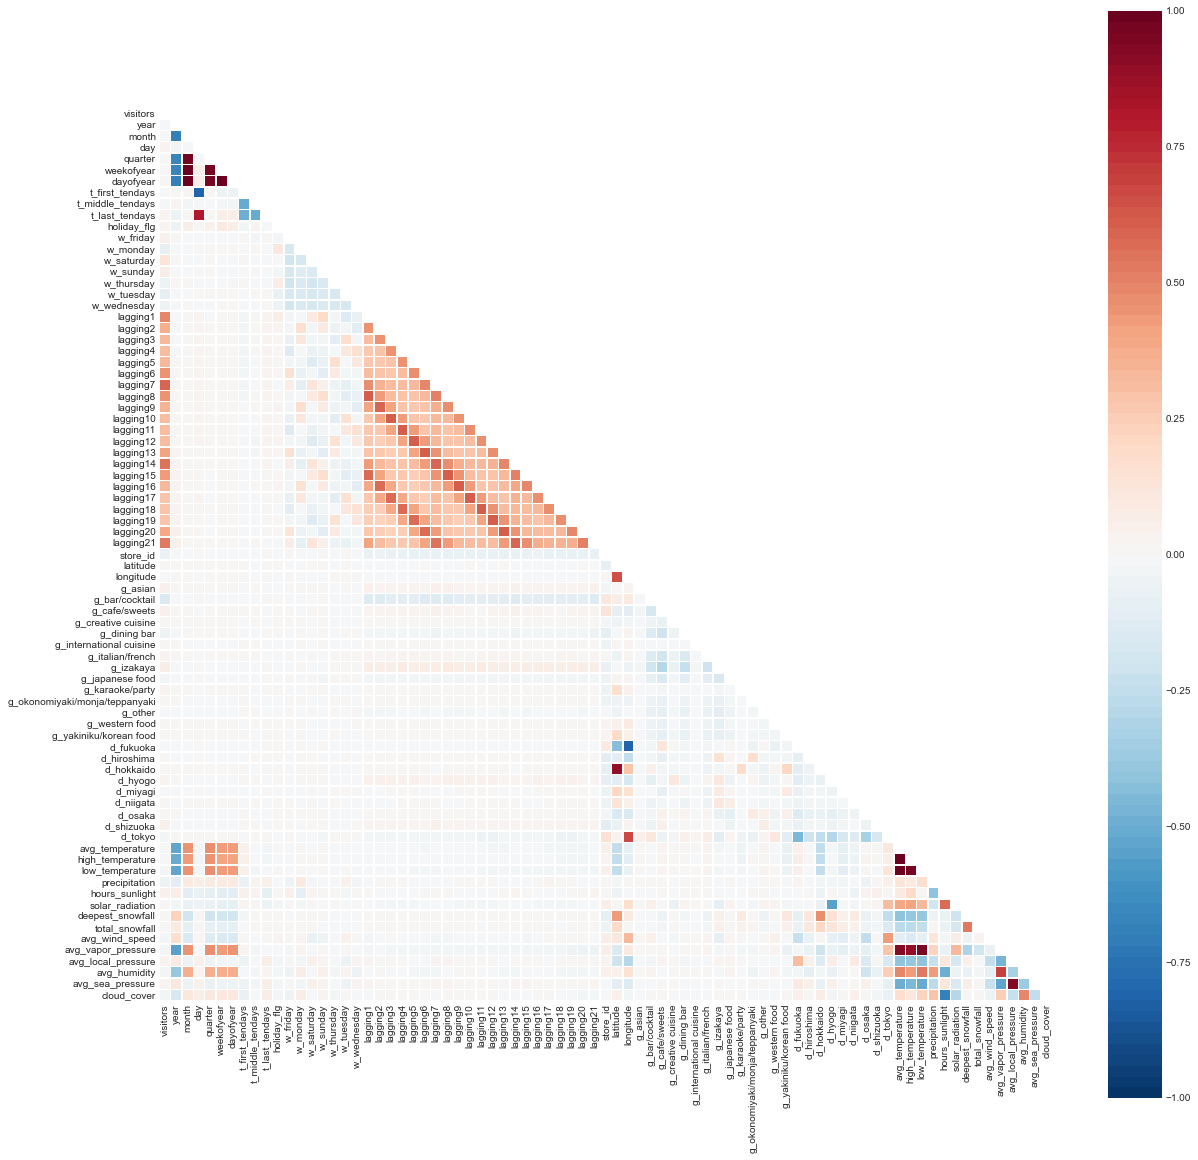

In [97]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20, 20))

mask = np.zeros_like(dataset.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset.corr(),
            vmin=-1, vmax=1,
            square=True,
            cmap=sns.color_palette("RdBu_r", 100),
            mask=mask,
            linewidths=.5)
plt.savefig('img/feature_correlation.png', dpi=300, bbox_inches='tight')

#### 小结：当天客流量同前一些天的流量关系比较紧密，也呈现以周为单位的周期趋势，时间与天气特征也呈现一定相关性，不同的天气特征也呈现一定相关性。

### 2.特征重要性

In [98]:
rfr = RandomForestRegressor(n_jobs=-1, random_state=42)
rfr.fit(X, y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [99]:
X.shape

(252108, 78)

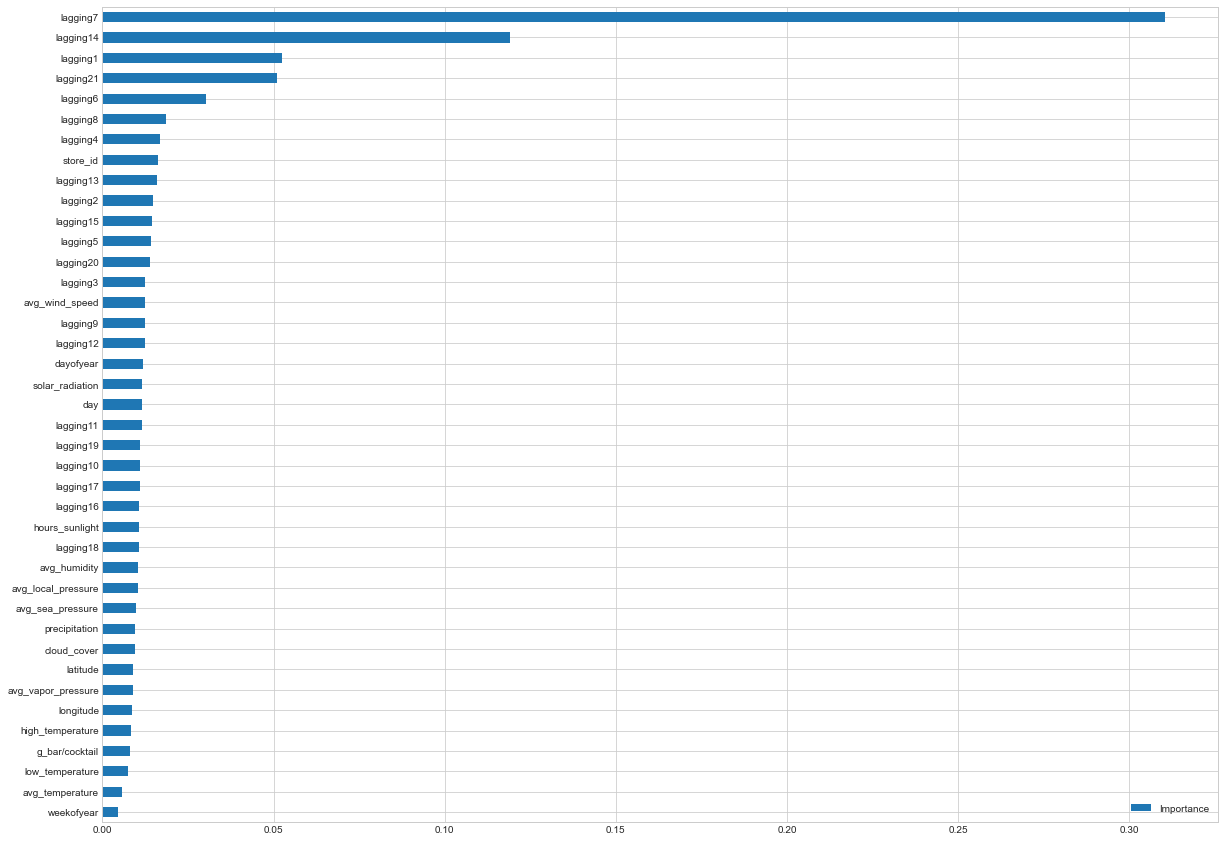

In [100]:
importance = rfr.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True)[-40:].plot(
    kind='barh', figsize=(20, 15))
plt.savefig('img/feature_importance.png', dpi=300, bbox_inches='tight')

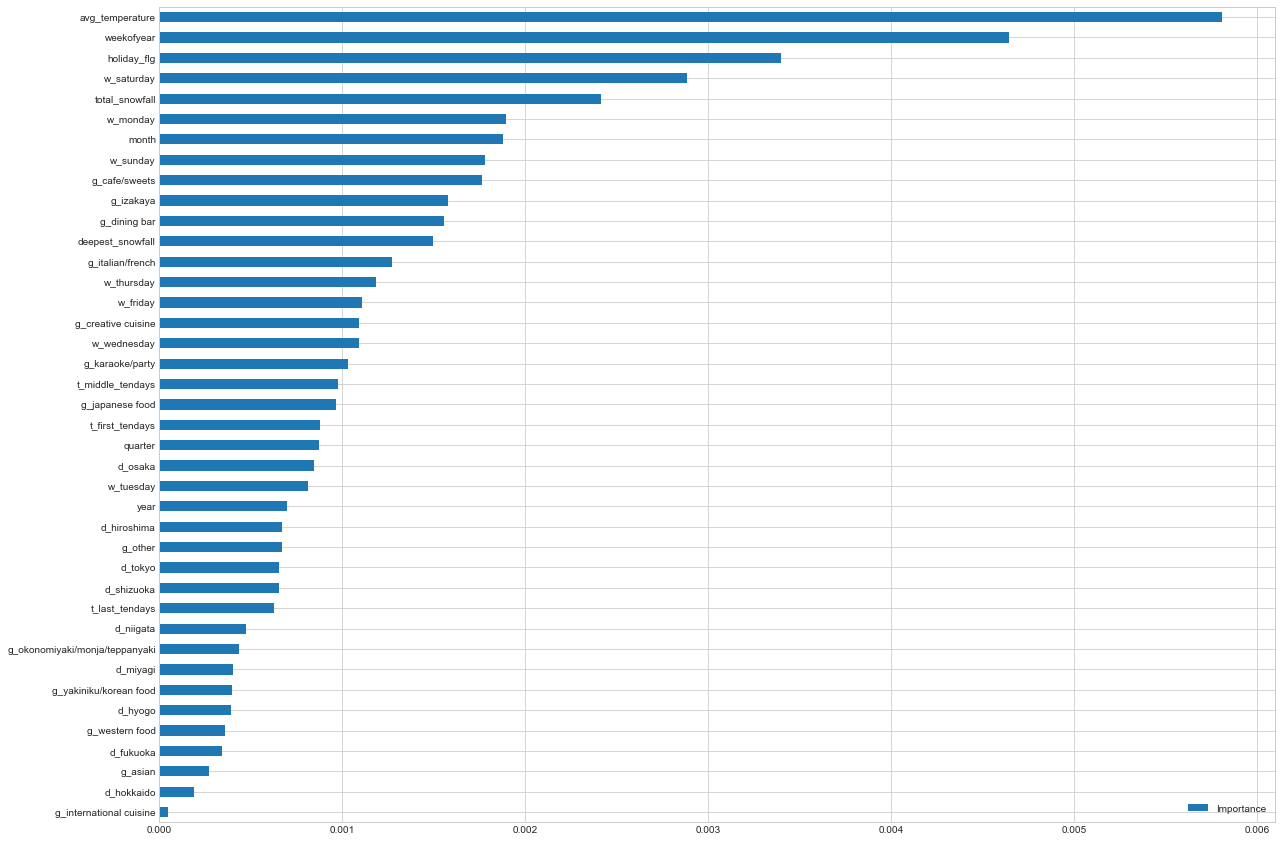

In [101]:
importance = rfr.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True)[:40].plot(
    kind='barh', figsize=(20, 15))
plt.savefig('img/feature_not_importance.png', dpi=300, bbox_inches='tight')

#### 小结：从特征重要性的图和不要重要特征的图可以看出，除了时间序列的客流特征外，天气特征很多在前面，加上天气类特征还是有作用的。

## 七、对比不同算法
[回到目录](#目录)

### 分别尝试下不同机器学习算法的效果：

- LinearRegression
- Ridge
- Lasso
- SGDRegressor
- DecisionTreeRegressor
- RandomForestRegressor
- AdaBoostRegressor
- GradientBoostingRegressor
- LinearSVR

使用的评价指标：
- MAE
- RMSE
- MSLE
- r2_score

In [102]:
# 归一化处理
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y, test_size=0.2, shuffle=True, random_state=12)

In [103]:
import time
import datetime

# 综合训练和计算指标的函数


def fit_ml_algo(algo, X_train, y_train, X_test, y_test, cv):
    print('*'*10, algo.__class__.__name__, '*'*10)
    # 单步计算
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    test_pred = np.where(test_pred < 0, 0, test_pred)  # 预测出来的客流量必须大于等于0
    test_mae = mean_absolute_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_msle = mean_squared_log_error(
        y_test, test_pred)  # 对于人口、客流这种不能为0的数据可以用MSLE来评价
    test_r2 = r2_score(y_test, test_pred)
    # CV计算
    cv_pred = cross_val_predict(algo, X_train, y_train, cv=cv, n_jobs=-1)
    cv_pred = np.where(cv_pred < 0, 0, cv_pred)  # 预测出来的客流量必须大于等于0
    cv_mae = mean_absolute_error(y_train, cv_pred)
    cv_rmse = np.sqrt(mean_squared_error(y_train, cv_pred))
    cv_msle = mean_squared_log_error(
        y_train, cv_pred)  # 对于人口、客流这种不能为0的数据可以用MSLE来评价
    cv_r2 = r2_score(y_train, cv_pred)
    return test_pred, cv_pred, test_mae, cv_mae, test_rmse, cv_rmse, test_msle, cv_msle, test_r2, cv_r2

In [104]:
cv = 5
start_time = time.time()
lr_test_pred, lr_cv_pred, lr_test_mae, lr_cv_mae, lr_test_rmse, lr_cv_rmse, lr_test_msle, lr_cv_msle, lr_test_r2, lr_cv_r2 = fit_ml_algo(
    LinearRegression(n_jobs=-1), X_train, y_train, X_test, y_test, cv)
lr_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(lr_test_mae, cv, lr_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(lr_test_rmse, cv, lr_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(lr_test_msle, cv, lr_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(lr_test_r2, cv, lr_cv_r2))
print('Running Time {0:.2f}s'.format(lr_time))

********** LinearRegression **********
Test MAE: 7.86, 5-Fold CV MAE: 7.81
Test RMSE: 11.71, 5-Fold CV RMSE: 11.98
Test MSLE: 0.3505, 5-Fold CV MSLE: 0.3515
Test R2 Score: 0.4974, 5-Fold CV R2 Score: 0.4927
Running Time 5.09s


In [105]:
cv = 5
start_time = time.time()
rd_test_pred, rd_cv_pred, rd_test_mae, rd_cv_mae, rd_test_rmse, rd_cv_rmse, rd_test_msle, rd_cv_msle, rd_test_r2, rd_cv_r2 = fit_ml_algo(
    Ridge(), X_train, y_train, X_test, y_test, cv)
rd_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(rd_test_mae, cv, rd_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(rd_test_rmse, cv, rd_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(rd_test_msle, cv, rd_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(rd_test_r2, cv, rd_cv_r2))
print('Running Time {0:.2f}s'.format(rd_time))

********** Ridge **********
Test MAE: 7.86, 5-Fold CV MAE: 7.82
Test RMSE: 11.72, 5-Fold CV RMSE: 11.98
Test MSLE: 0.3513, 5-Fold CV MSLE: 0.3522
Test R2 Score: 0.4972, 5-Fold CV R2 Score: 0.4926
Running Time 2.35s


In [106]:
cv = 5
start_time = time.time()
ls_test_pred, ls_cv_pred, ls_test_mae, ls_cv_mae, ls_test_rmse, ls_cv_rmse, ls_test_msle, ls_cv_msle, ls_test_r2, ls_cv_r2 = fit_ml_algo(
    Lasso(), X_train, y_train, X_test, y_test, cv)
ls_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(ls_test_mae, cv, ls_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(ls_test_rmse, cv, ls_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(ls_test_msle, cv, ls_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(ls_test_r2, cv, ls_cv_r2))
print('Running Time {0:.2f}s'.format(ls_time))

********** Lasso **********
Test MAE: 12.45, 5-Fold CV MAE: 12.49
Test RMSE: 16.52, 5-Fold CV RMSE: 16.82
Test MSLE: 0.7243, 5-Fold CV MSLE: 0.7367
Test R2 Score: -0.0000, 5-Fold CV R2 Score: -0.0000
Running Time 1.68s


In [107]:
cv = 5
start_time = time.time()
dt_test_pred, dt_cv_pred, dt_test_mae, dt_cv_mae, dt_test_rmse, dt_cv_rmse, dt_test_msle, dt_cv_msle, dt_test_r2, dt_cv_r2 = fit_ml_algo(
    DecisionTreeRegressor(), X_train, y_train, X_test, y_test, cv)
dt_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(dt_test_mae, cv, dt_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(dt_test_rmse, cv, dt_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(dt_test_msle, cv, dt_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(dt_test_r2, cv, dt_cv_r2))
print('Running Time {0:.2f}s'.format(dt_time))

********** DecisionTreeRegressor **********
Test MAE: 10.84, 5-Fold CV MAE: 10.72
Test RMSE: 17.45, 5-Fold CV RMSE: 16.70
Test MSLE: 0.6072, 5-Fold CV MSLE: 0.6041
Test R2 Score: -0.1154, 5-Fold CV R2 Score: 0.0134
Running Time 28.00s


In [108]:
cv = 5
start_time = time.time()
sgd_test_pred, sgd_cv_pred, sgd_test_mae, sgd_cv_mae, sgd_test_rmse, sgd_cv_rmse, sgd_test_msle, sgd_cv_msle, sgd_test_r2, sgd_cv_r2 = fit_ml_algo(
    SGDRegressor(), X_train, y_train, X_test, y_test, cv)
sgd_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(sgd_test_mae, cv, sgd_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(sgd_test_rmse, cv, sgd_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(sgd_test_msle, cv, sgd_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(sgd_test_r2, cv, sgd_cv_r2))
print('Running Time {0:.2f}s'.format(sgd_time))

********** SGDRegressor **********
Test MAE: 7.94, 5-Fold CV MAE: 7.89
Test RMSE: 11.77, 5-Fold CV RMSE: 12.06
Test MSLE: 0.3577, 5-Fold CV MSLE: 0.3578
Test R2 Score: 0.4922, 5-Fold CV R2 Score: 0.4860
Running Time 46.28s


In [109]:
cv = 5
start_time = time.time()
svr_test_pred, svr_cv_pred, svr_test_mae, svr_cv_mae, svr_test_rmse, svr_cv_rmse, svr_test_msle, svr_cv_msle, svr_test_r2, svr_cv_r2 = fit_ml_algo(
    LinearSVR(), X_train, y_train, X_test, y_test, cv)
svr_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(svr_test_mae, cv, svr_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(svr_test_rmse, cv, svr_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(svr_test_msle, cv, svr_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(svr_test_r2, cv, svr_cv_r2))
print('Running Time {0:.2f}s'.format(svr_time))

********** LinearSVR **********
Test MAE: 7.78, 5-Fold CV MAE: 7.75
Test RMSE: 11.82, 5-Fold CV RMSE: 12.11
Test MSLE: 0.3413, 5-Fold CV MSLE: 0.3414
Test R2 Score: 0.4879, 5-Fold CV R2 Score: 0.4815
Running Time 4.41s


In [110]:
cv = 5
start_time = time.time()
rf_test_pred, rf_cv_pred, rf_test_mae, rf_cv_mae, rf_test_rmse, rf_cv_rmse, rf_test_msle, rf_cv_msle, rf_test_r2, rf_cv_r2 = fit_ml_algo(
    RandomForestRegressor(n_jobs=4, n_estimators=50), X_train, y_train, X_test, y_test, cv)
rf_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(rf_test_mae, cv, rf_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(rf_test_rmse, cv, rf_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(rf_test_msle, cv, rf_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(rf_test_r2, cv, rf_cv_r2))
print('Running Time {0:.2f}s'.format(rf_time))

********** RandomForestRegressor **********
Test MAE: 7.51, 5-Fold CV MAE: 7.49
Test RMSE: 11.24, 5-Fold CV RMSE: 11.66
Test MSLE: 0.3208, 5-Fold CV MSLE: 0.3256
Test R2 Score: 0.5373, 5-Fold CV R2 Score: 0.5193
Running Time 456.76s


In [111]:
cv = 5
start_time = time.time()
adb_test_pred, adb_cv_pred, adb_test_mae, adb_cv_mae, adb_test_rmse, adb_cv_rmse, adb_test_msle, adb_cv_msle, adb_test_r2, adb_cv_r2 = fit_ml_algo(
    AdaBoostRegressor(n_estimators=50), X_train, y_train, X_test, y_test, cv)
adb_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(adb_test_mae, cv, adb_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(adb_test_rmse, cv, adb_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(adb_test_msle, cv, adb_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(adb_test_r2, cv, adb_cv_r2))
print('Running Time {0:.2f}s'.format(adb_time))

********** AdaBoostRegressor **********
Test MAE: 27.47, 5-Fold CV MAE: 29.47
Test RMSE: 30.35, 5-Fold CV RMSE: 35.38
Test MSLE: 1.6211, 5-Fold CV MSLE: 1.6869
Test R2 Score: -2.3739, 5-Fold CV R2 Score: -3.4276
Running Time 177.93s


In [112]:
cv = 5
start_time = time.time()
gb_test_pred, gb_cv_pred, gb_test_mae, gb_cv_mae, gb_test_rmse, gb_cv_rmse, gb_test_msle, gb_cv_msle, gb_test_r2, gb_cv_r2 = fit_ml_algo(
    GradientBoostingRegressor(n_estimators=50), X_train, y_train, X_test, y_test, cv)
gb_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(gb_test_mae, cv, gb_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(gb_test_rmse, cv, gb_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(gb_test_msle, cv, gb_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(gb_test_r2, cv, gb_cv_r2))
print('Running Time {0:.2f}s'.format(gb_time))

********** GradientBoostingRegressor **********
Test MAE: 7.67, 5-Fold CV MAE: 7.63
Test RMSE: 11.35, 5-Fold CV RMSE: 11.70
Test MSLE: 0.3474, 5-Fold CV MSLE: 0.3492
Test R2 Score: 0.5284, 5-Fold CV R2 Score: 0.5162
Running Time 195.19s


In [114]:
# 对比不同模型测试集评分
model = ['LinearRegression', 'Ridge', 'Lasso',
         'SGDRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor',
         'AdaBoostRegressor', 'GradientBoostingRegressor', 'LinearSVR', ]
mae = [lr_test_mae, rd_test_mae, ls_test_mae,
       sgd_test_mae, dt_test_mae, rf_test_mae,
       adb_test_mae, gb_test_mae, svr_test_mae]
rmse = [lr_test_rmse, rd_test_rmse, ls_test_rmse,
        sgd_test_rmse, dt_test_rmse, rf_test_rmse,
        adb_test_rmse, gb_test_rmse, svr_test_rmse]
msle = [lr_test_msle, rd_test_msle, ls_test_msle,
        sgd_test_msle, dt_test_msle, rf_test_msle,
        adb_test_msle, gb_test_msle, svr_test_msle]
r2 = [lr_test_r2, rd_test_r2, ls_test_r2,
      sgd_test_r2, dt_test_r2, rf_test_r2,
      adb_test_r2, gb_test_r2, svr_test_r2]
time_ = [lr_time, rd_time, ls_time,
         sgd_time, dt_time, rf_time,
         adb_time, gb_time, svr_time]
models_test = pd.DataFrame({
    'Model': model,
    'MAE': mae,
    'RMSE': rmse,
    'MSLE': msle,
    'R2': r2,
    'Time': time_,
})
models_test['R2/T'] = models_test['R2']/models_test['Time']
models_test['MSLE*T'] = models_test['MSLE']*models_test['Time']

In [115]:
# 用R2来评价效果
models_test.sort_values(by='R2', ascending=False)

,Model,MAE,RMSE,MSLE,R2,Time,R2/T,MSLE*T
5,RandomForestRegressor,7.507334,11.238114,0.320777,0.537343,456.755106,0.001176,146.516608
7,GradientBoostingRegressor,7.671093,11.346430,0.347423,0.528382,195.187481,0.002707,67.812708
0,LinearRegression,7.856792,11.712985,0.350523,0.497417,5.089912,0.097726,1.784129
1,Ridge,7.861516,11.715017,0.351341,0.497243,2.346437,0.211914,0.824400
3,SGDRegressor,7.936339,11.773222,0.357705,0.492235,46.284707,0.010635,16.556269
8,LinearSVR,7.784542,11.823435,0.341323,0.487894,4.411490,0.110596,1.505742
2,Lasso,12.446545,16.522442,0.724306,-0.000048,1.679905,-0.000028,1.216766
4,DecisionTreeRegressor,10.838444,17.449505,0.607225,-0.115420,28.002396,-0.004122,17.003769
6,AdaBoostRegressor,27.470011,30.348040,1.621129,-2.373910,177.933708,-0.013342,288.453519


In [116]:
# 用MSLE与时间的乘积来评价效率，两者都是越小越好，
models_test.sort_values(by='MSLE*T', ascending=True)

,Model,MAE,RMSE,MSLE,R2,Time,R2/T,MSLE*T
1,Ridge,7.861516,11.715017,0.351341,0.497243,2.346437,0.211914,0.824400
2,Lasso,12.446545,16.522442,0.724306,-0.000048,1.679905,-0.000028,1.216766
8,LinearSVR,7.784542,11.823435,0.341323,0.487894,4.411490,0.110596,1.505742
0,LinearRegression,7.856792,11.712985,0.350523,0.497417,5.089912,0.097726,1.784129
3,SGDRegressor,7.936339,11.773222,0.357705,0.492235,46.284707,0.010635,16.556269
4,DecisionTreeRegressor,10.838444,17.449505,0.607225,-0.115420,28.002396,-0.004122,17.003769
7,GradientBoostingRegressor,7.671093,11.346430,0.347423,0.528382,195.187481,0.002707,67.812708
5,RandomForestRegressor,7.507334,11.238114,0.320777,0.537343,456.755106,0.001176,146.516608
6,AdaBoostRegressor,27.470011,30.348040,1.621129,-2.373910,177.933708,-0.013342,288.453519


In [117]:
# 对比不同模型CV评分
model = ['LinearRegression', 'Ridge', 'Lasso',
         'SGDRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor',
         'AdaBoostRegressor', 'GradientBoostingRegressor', 'LinearSVR', ]
mae = [lr_cv_mae, rd_cv_mae, ls_cv_mae,
       sgd_cv_mae, dt_cv_mae, rf_cv_mae,
       adb_cv_mae, gb_cv_mae, svr_cv_mae]
rmse = [lr_cv_rmse, rd_cv_rmse, ls_cv_rmse,
        sgd_cv_rmse, dt_cv_rmse, rf_cv_rmse,
        adb_cv_rmse, gb_cv_rmse, svr_cv_rmse]
msle = [lr_cv_msle, rd_cv_msle, ls_cv_msle,
        sgd_cv_msle, dt_cv_msle, rf_cv_msle,
        adb_cv_msle, gb_cv_msle, svr_cv_msle]
r2 = [lr_cv_r2, rd_cv_r2, ls_cv_r2,
      sgd_cv_r2, dt_cv_r2, rf_cv_r2,
      adb_cv_r2, gb_cv_r2, svr_cv_r2]
time_ = [lr_time, rd_time, ls_time,
         sgd_time, dt_time, rf_time,
         adb_time, gb_time, svr_time]
models_cv = pd.DataFrame({
    'Model': model,
    'MAE': mae,
    'RMSE': rmse,
    'MSLE': msle,
    'R2': r2,
    'Time': time_,
})
models_cv['R2/T'] = models_cv['R2']/models_cv['Time']
models_cv['MSLE*T'] = models_cv['MSLE']*models_cv['Time']

In [118]:
models_cv.sort_values(by='R2', ascending=False)

,Model,MAE,RMSE,MSLE,R2,Time,R2/T,MSLE*T
5,RandomForestRegressor,7.487197,11.658685,0.325616,0.519272,456.755106,0.001137,148.726846
7,GradientBoostingRegressor,7.626443,11.695369,0.349247,0.516242,195.187481,0.002645,68.168640
0,LinearRegression,7.810610,11.975990,0.351492,0.492749,5.089912,0.096809,1.789061
1,Ridge,7.815677,11.977529,0.352198,0.492618,2.346437,0.209943,0.826410
3,SGDRegressor,7.894712,12.055534,0.357761,0.485988,46.284707,0.010500,16.558844
8,LinearSVR,7.747722,12.107841,0.341401,0.481518,4.411490,0.109151,1.506086
4,DecisionTreeRegressor,10.721532,16.702260,0.604079,0.013378,28.002396,0.000478,16.915660
2,Lasso,12.488432,16.815223,0.736712,-0.000013,1.679905,-0.000008,1.237607
6,AdaBoostRegressor,29.471407,35.382002,1.686878,-3.427566,177.933708,-0.019263,300.152534


In [119]:
models_cv.sort_values(by='MSLE*T', ascending=True)

,Model,MAE,RMSE,MSLE,R2,Time,R2/T,MSLE*T
1,Ridge,7.815677,11.977529,0.352198,0.492618,2.346437,0.209943,0.826410
2,Lasso,12.488432,16.815223,0.736712,-0.000013,1.679905,-0.000008,1.237607
8,LinearSVR,7.747722,12.107841,0.341401,0.481518,4.411490,0.109151,1.506086
0,LinearRegression,7.810610,11.975990,0.351492,0.492749,5.089912,0.096809,1.789061
3,SGDRegressor,7.894712,12.055534,0.357761,0.485988,46.284707,0.010500,16.558844
4,DecisionTreeRegressor,10.721532,16.702260,0.604079,0.013378,28.002396,0.000478,16.915660
7,GradientBoostingRegressor,7.626443,11.695369,0.349247,0.516242,195.187481,0.002645,68.168640
5,RandomForestRegressor,7.487197,11.658685,0.325616,0.519272,456.755106,0.001137,148.726846
6,AdaBoostRegressor,29.471407,35.382002,1.686878,-3.427566,177.933708,-0.019263,300.152534


#### 小结：从测试集和CV计算的结果来看，从效果来指标MAE, RMSE, MSLE, R2来看，随机森林最优，然后是梯度提升算法；从时间效率指标来看，岭回归是最快的，也接近0.5，接下来也进行高参看看能不能有进一步提升。

## 八、优化模型调参
[回到目录](#目录)

In [6]:
# 读取数据
data_w_weather = pd.read_csv('data_set/data_w_weather_fill0.csv')
dataset = data_w_weather.drop(
    ['id', 'visit_date', 'area', 'district', 'city', 'county'], axis=1)
X = dataset.drop('visitors', axis=1)
y = dataset['visitors']

In [7]:
# 归一化处理
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
# 划分数据
X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y, test_size=0.2, shuffle=True, random_state=12)

### 1.计算优化后的线性回归模型，作为指标参考

In [120]:
from pprint import pprint
lr = LinearRegression()
# 打印所有参数
pprint(lr.get_params())

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


In [121]:
import time
# 定义参数
param_grid = {"copy_X": [True, False],
              'fit_intercept': [True, False],
              "normalize": [True, False], }

# 网络搜索
lr = LinearRegression(n_jobs=-1)
lr_grid_search = GridSearchCV(
    estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)
start = time.time()
lr_grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for best parameter settings." %
      ((time.time() - start)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.5s finished


GridSearchCV took 15.34 seconds for best parameter settings.


In [122]:
# 最优参数
lr_best_params = lr_grid_search.best_params_
lr_best_params

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

In [123]:
import joblib
# 最优模型
lr_best = lr_grid_search.best_estimator_
joblib.dump(lr_best, "./lr_best.pkl")  # 保存算法文件

['./lr_best.pkl']

In [124]:
cv = 5
start_time = time.time()
lr_test_pred, lr_cv_pred, lr_test_mae, lr_cv_mae, lr_test_rmse, lr_cv_rmse, lr_test_msle, lr_cv_msle, lr_test_r2, lr_cv_r2 = fit_ml_algo(
    lr_best, X_train, y_train, X_test, y_test, cv)
lr_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(lr_test_mae, cv, lr_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(lr_test_rmse, cv, lr_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(lr_test_msle, cv, lr_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(lr_test_r2, cv, lr_cv_r2))
print('Running Time {0:.2f}s'.format(lr_time))

********** LinearRegression **********
Test MAE: 7.86, 5-Fold CV MAE: 7.81
Test RMSE: 11.71, 5-Fold CV RMSE: 11.98
Test MSLE: 0.3505, 5-Fold CV MSLE: 0.3515
Test R2 Score: 0.4974, 5-Fold CV R2 Score: 0.4928
Running Time 2.69s


### 2.优化岭回归模型

In [125]:
rd = Ridge()
# 打印所有参数
pprint(rd.get_params())

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}


In [126]:
# 打印最优分数的超参数
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# 定义参数范围
param_dist = {"copy_X": [True, False],
              'fit_intercept': [True, False],
              "normalize": [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
              'alpha': np.logspace(-10, 10, 1000),
              'max_iter': [int(x) for x in np.arange(start=20, stop=2001, step=20)]}

# 运行随机搜索
n_iter_search = 50
rd = Ridge(random_state=12)
rd_random_search = RandomizedSearchCV(
    rd, n_jobs=-1, n_iter=n_iter_search, cv=3, verbose=3, scoring='r2', param_distributions=param_dist, )

start = time.time()
rd_random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(rd_random_search.cv_results_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.6min finished


RandomizedSearchCV took 218.76 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'cholesky', 'normalize': False, 'max_iter': 400, 'fit_intercept': True, 'copy_X': False, 'alpha': 0.0032174181506763717}

Model with rank: 2
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'auto', 'normalize': False, 'max_iter': 780, 'fit_intercept': False, 'copy_X': True, 'alpha': 0.0008850074914473439}

Model with rank: 3
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'auto', 'normalize': False, 'max_iter': 1200, 'fit_intercept': True, 'copy_X': True, 'alpha': 5.3177231778509664e-05}

Model with rank: 4
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'svd', 'normalize': False, 'max_iter': 40, 'fit_intercept': False, 'copy_X': True, 'alpha': 8.809371904473992e-06}

Model with rank: 5
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'sag', 'normalize'

In [127]:
# 打印最优分数的超参数
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# 定义参数范围
param_dist = {"copy_X": [True, False],
              'fit_intercept': [True, False],
              "normalize": [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
              'alpha': np.logspace(-10, 10, 1000),
              'max_iter': [int(x) for x in np.arange(start=20, stop=2001, step=20)]}

# 运行随机搜索
n_iter_search = 50
rd = Ridge(random_state=18)
rd_random_search = RandomizedSearchCV(
    rd, n_jobs=-1, n_iter=n_iter_search, cv=3, verbose=3, scoring='r2', param_distributions=param_dist, )

start = time.time()
rd_random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(rd_random_search.cv_results_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.3min finished


RandomizedSearchCV took 195.82 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'auto', 'normalize': False, 'max_iter': 1920, 'fit_intercept': True, 'copy_X': False, 'alpha': 0.002555097090352507}

Model with rank: 2
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'svd', 'normalize': True, 'max_iter': 1500, 'fit_intercept': True, 'copy_X': True, 'alpha': 2.64498018242772e-08}

Model with rank: 3
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'svd', 'normalize': True, 'max_iter': 980, 'fit_intercept': True, 'copy_X': False, 'alpha': 6.335804992658241e-09}

Model with rank: 4
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'cholesky', 'normalize': True, 'max_iter': 800, 'fit_intercept': True, 'copy_X': False, 'alpha': 4.588404126454752e-09}

Model with rank: 5
Mean validation score: 0.4930 (std: 0.0068)
Parameters: {'solver': 'sag', 'normalize': Fal

In [128]:
# 最优模型
rd_best = rd_random_search.best_estimator_
joblib.dump(lr_best, "./rd_best.pkl")  # 保存算法文件

['./rd_best.pkl']

In [129]:
# 最优参数
rd_best_params = rd_random_search.best_params_
rd_best_params

{'solver': 'auto',
 'normalize': False,
 'max_iter': 1920,
 'fit_intercept': True,
 'copy_X': False,
 'alpha': 0.002555097090352507}

In [130]:
cv = 5
start_time = time.time()
rd_test_pred, rd_cv_pred, rd_test_mae, rd_cv_mae, rd_test_rmse, rd_cv_rmse, rd_test_msle, rd_cv_msle, rd_test_r2, rd_cv_r2 = fit_ml_algo(
    rd_best, X_train, y_train, X_test, y_test, cv)
rd_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(rd_test_mae, cv, rd_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(rd_test_rmse, cv, rd_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(rd_test_msle, cv, rd_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(rd_test_r2, cv, rd_cv_r2))
print('Running Time {0:.2f}s'.format(lr_time))

********** Ridge **********
Test MAE: 18.44, 5-Fold CV MAE: 7.81
Test RMSE: 20.70, 5-Fold CV RMSE: 11.97
Test MSLE: 1.0702, 5-Fold CV MSLE: 0.3515
Test R2 Score: -0.5696, 5-Fold CV R2 Score: 0.4928
Running Time 2.69s


#### 小结：两次随机搜索中，所有排名前5的R2评分一样，无论是怎么样的参数，本以为岭回归比线性回归有更多参数，调参可以有提升的空间，但模型算法本身也决定调参有没有作用，简单的线性模型，基本没有提升空间。

### 3.优化随机森林算法

In [131]:
rf = RandomForestRegressor()
# 打印所有参数
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [132]:
# 打印最优分数的超参数
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# 定义参数范围
param_dist = {'n_estimators': [int(x) for x in np.arange(start=30, stop=151, step=15)],
              "max_depth": [10, 15, None],
              "min_samples_leaf": sp_randint(1, 81),
              "min_samples_split": sp_randint(10, 301),
              "max_features": sp_randint(20, 61),
              "bootstrap": [True, False]}


# 运行随机搜索
n_iter_search = 10
rf = RandomForestRegressor(random_state=12, n_jobs=4)
rf_random_search = RandomizedSearchCV(
    rf, n_jobs=-1, n_iter=n_iter_search, cv=3, verbose=10, scoring='r2', param_distributions=param_dist, )

start = time.time()
rf_random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(rf_random_search.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 14.7min remaining:  8.5min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 16.3min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 20.6min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 21.8min finished


RandomizedSearchCV took 1485.96 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.5382 (std: 0.0087)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 68, 'n_estimators': 150}

Model with rank: 2
Mean validation score: 0.5298 (std: 0.0090)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 37, 'min_samples_leaf': 28, 'min_samples_split': 252, 'n_estimators': 135}

Model with rank: 3
Mean validation score: 0.5296 (std: 0.0086)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 50, 'min_samples_leaf': 15, 'min_samples_split': 212, 'n_estimators': 60}

Model with rank: 4
Mean validation score: 0.5260 (std: 0.0088)
Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 36, 'min_samples_leaf': 74, 'min_samples_split': 87, 'n_estimators': 75}

Model with rank: 5
Mean validation score: 0.5255 (std: 0.0086)
Parameters: {'bootstrap': True, 'max_depth'

In [133]:
# 打印最优分数的超参数
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# 定义参数范围
param_dist = {'n_estimators': [int(x) for x in np.arange(start=30, stop=106, step=15)],
              "max_depth": [10, 15, None],
              "min_samples_leaf": sp_randint(1, 81),
              "min_samples_split": sp_randint(11, 201),
              "max_features": sp_randint(21, 51),
              "bootstrap": [True, False]}


# 运行随机搜索
n_iter_search = 10
rf = RandomForestRegressor(random_state=18, n_jobs=4)
rf_random_search = RandomizedSearchCV(
    rf, n_jobs=-1, n_iter=n_iter_search, cv=3, verbose=10, scoring='r2', param_distributions=param_dist, )

start = time.time()
rf_random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(rf_random_search.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 10.7min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 12.0min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 14.2min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.4min finished


RandomizedSearchCV took 936.56 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.5340 (std: 0.0087)
Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 48, 'min_samples_leaf': 28, 'min_samples_split': 19, 'n_estimators': 75}

Model with rank: 2
Mean validation score: 0.5329 (std: 0.0089)
Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 34, 'min_samples_leaf': 47, 'min_samples_split': 84, 'n_estimators': 75}

Model with rank: 3
Mean validation score: 0.5318 (std: 0.0086)
Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 37, 'min_samples_leaf': 49, 'min_samples_split': 95, 'n_estimators': 60}

Model with rank: 4
Mean validation score: 0.5298 (std: 0.0085)
Parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 45, 'min_samples_leaf': 38, 'min_samples_split': 123, 'n_estimators': 60}

Model with rank: 5
Mean validation score: 0.5287 (std: 0.0084)
Parameters: {'bootstrap': False, 'max_depth

In [136]:
# 定义参数
param_grid = {"max_depth": [15],
              'n_estimators': [150, 160],
              "max_features": [34, 37],
              "min_samples_split": [68, 76, 84],
              "min_samples_leaf": [4],
              "bootstrap": [False]}

# 网络搜索
rf = RandomForestRegressor(random_state=12, n_jobs=4)
rf_grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=10)
start = time.time()
rf_grid_search.fit(X_train, y_train)
print("GridSearchCV took %.2f seconds for best parameter settings." %
      ((time.time() - start)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 37.2min remaining: 16.4min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 38.7min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 42.9min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 43.4min finished


GridSearchCV took 2762.12 seconds for best parameter settings.


In [137]:
report(rf_grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.5382 (std: 0.0087)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 68, 'n_estimators': 160}

Model with rank: 2
Mean validation score: 0.5382 (std: 0.0087)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 68, 'n_estimators': 150}

Model with rank: 3
Mean validation score: 0.5379 (std: 0.0087)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 76, 'n_estimators': 160}

Model with rank: 4
Mean validation score: 0.5378 (std: 0.0086)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 76, 'n_estimators': 150}

Model with rank: 5
Mean validation score: 0.5377 (std: 0.0088)
Parameters: {'bootstrap': False, 'max_depth': 15, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 84, 'n_esti

In [138]:
# 最优参数
rf_best_params = rf_grid_search.best_params_
rf_best_params

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 34,
 'min_samples_leaf': 4,
 'min_samples_split': 68,
 'n_estimators': 160}

In [139]:
import joblib
# 最优模型
rf_best = rf_grid_search.best_estimator_
joblib.dump(rf_best, "./rf_best.pkl")  # 保存算法文件

['./rf_best.pkl']

In [140]:
cv = 5
start_time = time.time()
rf_test_pred, rf_cv_pred, rf_test_mae, rf_cv_mae, rf_test_rmse, rf_cv_rmse, rf_test_msle, rf_cv_msle, rf_test_r2, rf_cv_r2 = fit_ml_algo(
    rf_best, X_train, y_train, X_test, y_test, cv)
rf_time = time.time()-start_time
print(
    'Test MAE: {0:.2f}, {1}-Fold CV MAE: {2:.2f}'.format(rf_test_mae, cv, rf_cv_mae))
print(
    'Test RMSE: {0:.2f}, {1}-Fold CV RMSE: {2:.2f}'.format(rf_test_rmse, cv, rf_cv_rmse))
print(
    'Test MSLE: {0:.4f}, {1}-Fold CV MSLE: {2:.4f}'.format(rf_test_msle, cv, rf_cv_msle))
print(
    'Test R2 Score: {0:.4f}, {1}-Fold CV R2 Score: {2:.4f}'.format(rf_test_r2, cv, rf_cv_r2))
print('Running Time {0:.2f}s'.format(rf_time))

********** RandomForestRegressor **********
Test MAE: 18.33, 5-Fold CV MAE: 7.37
Test RMSE: 20.51, 5-Fold CV RMSE: 11.41
Test MSLE: 1.0750, 5-Fold CV MSLE: 0.3219
Test R2 Score: -0.5405, 5-Fold CV R2 Score: 0.5397
Running Time 605.60s


In [141]:
# 对比三个模型CV评分
model = ['LinearRegression', 'Ridge', 'RandomForestRegressor']
mae = [lr_cv_mae, rd_cv_mae, rf_cv_mae, ]
rmse = [lr_cv_rmse, rd_cv_rmse, rf_cv_rmse, ]
msle = [lr_cv_msle, rd_cv_msle, rf_cv_msle]
r2 = [lr_cv_r2, rd_cv_r2, rf_cv_r2]
time_ = [lr_time, rd_time, rf_time]
models_cv = pd.DataFrame({
    'Model': model,
    'MAE': mae,
    'RMSE': rmse,
    'MSLE': msle,
    'R2': r2,
    'Time': time_,
})

In [142]:
models_cv.sort_values(by='R2', ascending=False)

,Model,MAE,RMSE,MSLE,R2,Time
2,RandomForestRegressor,7.371924,11.408001,0.321899,0.539723,605.603992
1,Ridge,7.811288,11.974834,0.351468,0.492847,0.869991
0,LinearRegression,7.811697,11.975025,0.351496,0.492830,2.687986


#### 小结：随机森林经过调参后，R2指标从0.5193提到到0.5397，相当于2个百分点，也是有明显提升。其它集成算法的R2评分也差不多，调参后提升的百分点也在2左右。如果特征处理得更好，或者数据集的噪声少一些，模型提升好一点。

## 九、提交数据做相同特征处理
[回到目录](#目录)

### 1.读取数据，调整列

In [440]:
submission = pd.read_csv('data_set/sample_submission.csv')

In [441]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        32019 non-null  object
 1   visitors  32019 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.4+ KB


In [442]:
submission['visit_date'] = pd.to_datetime(
    submission['id'].str.split('_').str[-1])
submission['id1'] = submission['id'].str.split('_').str[0:-1]
submission['id'] = submission['id1'].str.join('_')

In [443]:
order = ['id', 'visit_date', 'visitors']
sub = submission[order]

In [444]:
sub.head()

,id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,0
1,air_00a91d42b08b08d9,2017-04-24,0
2,air_00a91d42b08b08d9,2017-04-25,0
3,air_00a91d42b08b08d9,2017-04-26,0
4,air_00a91d42b08b08d9,2017-04-27,0


### 2.添加时间特征数据

In [445]:
# 年份
sub['year'] = sub['visit_date'].dt.year
# 月份
sub['month'] = sub['visit_date'].dt.month
# 日期
sub['day'] = sub['visit_date'].dt.day
# 季度
sub['quarter'] = sub['visit_date'].dt.quarter
# 第几周
sub['weekofyear'] = sub['visit_date'].dt.weekofyear
# 第几天
sub['dayofyear'] = sub['visit_date'].dt.dayofyear

In [446]:
# 上旬、中旬、下旬
sub['t_first_tendays'] = 0
sub.loc[sub.day.isin(range(1, 11)), 't_first_tendays'] = 1
sub['t_middle_tendays'] = 0
sub.loc[sub.day.isin(range(11, 21)), 't_middle_tendays'] = 1
sub['t_last_tendays'] = 0
sub.loc[sub.day.isin(range(21, 32)), 't_last_tendays'] = 1

In [447]:
sub.sample(5)

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,t_middle_tendays,t_last_tendays
24808,air_c5459218282bedd5,2017-04-27,0,2017,4,27,2,17,117,0,0,1
9019,air_4d21676ed11f0bac,2017-05-03,0,2017,5,3,2,18,123,1,0,0
17418,air_8ec47c0f1e2c879e,2017-05-17,0,2017,5,17,2,20,137,0,1,0
6349,air_383f5b2f8d345a49,2017-05-24,0,2017,5,24,2,21,144,0,0,1
9076,air_4d71826793c09b22,2017-05-21,0,2017,5,21,2,20,141,0,0,1


In [448]:
# 合并dates数据表
dates['calendar_date'] = pd.to_datetime(dates['calendar_date'])
sub = pd.merge(sub, dates, how='left',
               left_on='visit_date', right_on='calendar_date')

In [449]:
sub.drop('calendar_date', axis=1, inplace=True)
sub.head()

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,t_middle_tendays,t_last_tendays,day_of_week,holiday_flg
0,air_00a91d42b08b08d9,2017-04-23,0,2017,4,23,2,16,113,0,0,1,Sunday,0
1,air_00a91d42b08b08d9,2017-04-24,0,2017,4,24,2,17,114,0,0,1,Monday,0
2,air_00a91d42b08b08d9,2017-04-25,0,2017,4,25,2,17,115,0,0,1,Tuesday,0
3,air_00a91d42b08b08d9,2017-04-26,0,2017,4,26,2,17,116,0,0,1,Wednesday,0
4,air_00a91d42b08b08d9,2017-04-27,0,2017,4,27,2,17,117,0,0,1,Thursday,0


In [450]:
# 星期的独热编码化
sub['day_of_week'] = sub['day_of_week'].str.lower()
week_encode = pd.get_dummies(sub['day_of_week'], prefix="w")
sub = sub.join(week_encode).drop('day_of_week', axis=1)
sub.head()

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,t_middle_tendays,t_last_tendays,holiday_flg,w_friday,w_monday,w_saturday,w_sunday,w_thursday,w_tuesday,w_wednesday
0,air_00a91d42b08b08d9,2017-04-23,0,2017,4,23,2,16,113,0,0,1,0,0,0,0,1,0,0,0
1,air_00a91d42b08b08d9,2017-04-24,0,2017,4,24,2,17,114,0,0,1,0,0,1,0,0,0,0,0
2,air_00a91d42b08b08d9,2017-04-25,0,2017,4,25,2,17,115,0,0,1,0,0,0,0,0,0,1,0
3,air_00a91d42b08b08d9,2017-04-26,0,2017,4,26,2,17,116,0,0,1,0,0,0,0,0,0,0,1
4,air_00a91d42b08b08d9,2017-04-27,0,2017,4,27,2,17,117,0,0,1,0,0,0,0,0,1,0,0


#### 3. 合并训练数据的时间特征，并生成连续21天的时间序列客流

In [451]:
data_w_weather = pd.read_csv(
    'data_set/data_w_weather_fill0.csv', parse_dates=['visit_date'])
data_w_weather.shape

(252108, 85)

In [452]:
temp = pd.concat([data_w_weather.iloc[:, 0:20], sub], axis=0)

In [453]:
temp

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,t_middle_tendays,t_last_tendays,holiday_flg,w_friday,w_monday,w_saturday,w_sunday,w_thursday,w_tuesday,w_wednesday
0,air_9438d67241c81314,2016-01-04,34,2016,1,4,1,1,4,1,0,0,0,0,1,0,0,0,0,0
1,air_9438d67241c81314,2016-01-05,25,2016,1,5,1,1,5,1,0,0,0,0,0,0,0,0,1,0
2,air_9438d67241c81314,2016-01-06,41,2016,1,6,1,1,6,1,0,0,0,0,0,0,0,0,0,1
3,air_9438d67241c81314,2016-01-07,30,2016,1,7,1,1,7,1,0,0,0,0,0,0,0,1,0,0
4,air_9438d67241c81314,2016-01-08,47,2016,1,8,1,1,8,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd,2017-05-27,0,2017,5,27,2,21,147,0,0,1,0,0,0,1,0,0,0,0
32015,air_fff68b929994bfbd,2017-05-28,0,2017,5,28,2,21,148,0,0,1,0,0,0,0,1,0,0,0
32016,air_fff68b929994bfbd,2017-05-29,0,2017,5,29,2,22,149,0,0,1,0,0,1,0,0,0,0,0
32017,air_fff68b929994bfbd,2017-05-30,0,2017,5,30,2,22,150,0,0,1,0,0,0,0,0,0,1,0


In [454]:
def create_lagging(df, df_original, i):
    df1 = df_original.copy()
    df1['visit_date'] = df1['visit_date'] + pd.DateOffset(
        days=i)
    df1 = df1.rename(columns={'visitors': 'lagging' + str(i)})
    df2 = pd.merge(df,
                   df1[['id', 'visit_date', 'lagging' + str(i)]],
                   on=['id', 'visit_date'],
                   how='left')
    return df2

In [455]:
sub1 = create_lagging(temp, temp, 1)

In [456]:
lagging = 21
for i in range(2, lagging+1):
    sub1 = create_lagging(sub1, temp, i)

In [458]:
dt_range = pd.date_range("2017-04-23", "2017-5-31", freq='1D')
sub1[sub1['visit_date'].isin(dt_range)]

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,...,lagging12,lagging13,lagging14,lagging15,lagging16,lagging17,lagging18,lagging19,lagging20,lagging21
252108,air_00a91d42b08b08d9,2017-04-23,0,2017,4,23,2,16,113,0,...,43.0,17.0,NaN,9.0,17.0,29.0,35.0,17.0,33.0,NaN
252109,air_00a91d42b08b08d9,2017-04-24,0,2017,4,24,2,17,114,0,...,28.0,43.0,17.0,NaN,9.0,17.0,29.0,35.0,17.0,33.0
252110,air_00a91d42b08b08d9,2017-04-25,0,2017,4,25,2,17,115,0,...,34.0,28.0,43.0,17.0,NaN,9.0,17.0,29.0,35.0,17.0
252111,air_00a91d42b08b08d9,2017-04-26,0,2017,4,26,2,17,116,0,...,39.0,34.0,28.0,43.0,17.0,NaN,9.0,17.0,29.0,35.0
252112,air_00a91d42b08b08d9,2017-04-27,0,2017,4,27,2,17,117,0,...,NaN,39.0,34.0,28.0,43.0,17.0,NaN,9.0,17.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,2017,5,27,2,21,147,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284123,air_fff68b929994bfbd,2017-05-28,0,2017,5,28,2,21,148,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284124,air_fff68b929994bfbd,2017-05-29,0,2017,5,29,2,22,149,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284125,air_fff68b929994bfbd,2017-05-30,0,2017,5,30,2,22,150,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 4.处理并合并店铺特征

In [462]:
# 店铺ID转换成连续数值
sub1['store_id'] = sub1['id'].factorize()[0]
sub1

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,...,lagging13,lagging14,lagging15,lagging16,lagging17,lagging18,lagging19,lagging20,lagging21,store_id
0,air_9438d67241c81314,2016-01-04,34,2016,1,4,1,1,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,air_9438d67241c81314,2016-01-05,25,2016,1,5,1,1,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,air_9438d67241c81314,2016-01-06,41,2016,1,6,1,1,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,air_9438d67241c81314,2016-01-07,30,2016,1,7,1,1,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,air_9438d67241c81314,2016-01-08,47,2016,1,8,1,1,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,2017,5,27,2,21,147,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,680
284123,air_fff68b929994bfbd,2017-05-28,0,2017,5,28,2,21,148,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,680
284124,air_fff68b929994bfbd,2017-05-29,0,2017,5,29,2,22,149,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,680
284125,air_fff68b929994bfbd,2017-05-30,0,2017,5,30,2,22,150,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,680


In [463]:
# 检查2017-04-23到2017-05-31的数据行是否与要提交数据的行数一致
sub1 = sub1[sub1['visit_date'].isin(dt_range)]
sub1

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,...,lagging13,lagging14,lagging15,lagging16,lagging17,lagging18,lagging19,lagging20,lagging21,store_id
252108,air_00a91d42b08b08d9,2017-04-23,0,2017,4,23,2,16,113,0,...,17.0,NaN,9.0,17.0,29.0,35.0,17.0,33.0,NaN,509
252109,air_00a91d42b08b08d9,2017-04-24,0,2017,4,24,2,17,114,0,...,43.0,17.0,NaN,9.0,17.0,29.0,35.0,17.0,33.0,509
252110,air_00a91d42b08b08d9,2017-04-25,0,2017,4,25,2,17,115,0,...,28.0,43.0,17.0,NaN,9.0,17.0,29.0,35.0,17.0,509
252111,air_00a91d42b08b08d9,2017-04-26,0,2017,4,26,2,17,116,0,...,34.0,28.0,43.0,17.0,NaN,9.0,17.0,29.0,35.0,509
252112,air_00a91d42b08b08d9,2017-04-27,0,2017,4,27,2,17,117,0,...,39.0,34.0,28.0,43.0,17.0,NaN,9.0,17.0,29.0,509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,air_fff68b929994bfbd,2017-05-27,0,2017,5,27,2,21,147,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,680
284123,air_fff68b929994bfbd,2017-05-28,0,2017,5,28,2,21,148,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,680
284124,air_fff68b929994bfbd,2017-05-29,0,2017,5,29,2,22,149,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,680
284125,air_fff68b929994bfbd,2017-05-30,0,2017,5,30,2,22,150,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,680


In [464]:
# 合并info数据表
sub = pd.merge(sub1, info, how='left', left_on='id', right_on='air_store_id')
sub.drop('air_store_id', axis=1, inplace=True)
sub.sample(5)

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,...,lagging17,lagging18,lagging19,lagging20,lagging21,store_id,air_genre_name,air_area_name,latitude,longitude
2071,air_142e78ba7001da9c,2017-04-27,0,2017,4,27,2,17,117,0,...,16.0,24.0,12.0,6.0,12.0,366,Italian/French,Hyōgo-ken Nishinomiya-shi Rokutanjichō,34.737597,135.341564
16933,air_8a906e5801eac81c,2017-04-30,0,2017,4,30,2,17,120,0,...,40.0,14.0,26.0,20.0,NaN,454,Other,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
21417,air_a88ac559064dec08,2017-04-29,0,2017,4,29,2,17,119,0,...,62.0,8.0,2.0,NaN,47.0,3,Creative cuisine,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813
23413,air_bac5f4441db21db9,2017-05-06,0,2017,5,6,2,18,126,1,...,35.0,NaN,28.0,69.0,64.0,430,Cafe/Sweets,Tōkyō-to Setagaya-ku Okusawa,35.602125,139.671958
29678,air_ecab54b57a71b10d,2017-05-31,0,2017,5,31,2,22,151,0,...,0.0,0.0,0.0,0.0,0.0,115,Izakaya,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018


In [465]:
# 简化名称，统一小写
sub = sub.rename(columns={'air_genre_name': 'genre', 'air_area_name': 'area'})
sub['genre'] = sub['genre'].str.lower()
sub['area'] = sub['area'].str.lower()

In [466]:
# 店铺类型独热编码化
genre_encode = pd.get_dummies(sub['genre'], prefix="g")
sub = sub.join(genre_encode).drop('genre', axis=1)

In [467]:
# 特殊字母处理
sub['area'] = sub['area'].str.replace('ō', 'o')
sub['area'] = sub['area'].str.replace('ū', 'u')
# 位置结尾有-to -ku -shi -fu -ken
sub['area'] = sub['area'].str.replace('-to', '')
sub['area'] = sub['area'].str.replace('-ku', '')
sub['area'] = sub['area'].str.replace('-shi', '')
sub['area'] = sub['area'].str.replace('-fu', '')
sub['area'] = sub['area'].str.replace('-ken', '')

In [468]:
# 提取每个店铺所在大区、市、县
sub['district'] = sub['area'].str.split(' ').str[0]
sub['city'] = sub['area'].str.split(' ').str[1]
sub['county'] = sub['area'].str.split(' ').str[2]

In [469]:
# 大区特征独热编码化
district_encode = pd.get_dummies(sub['district'], prefix="d")
sub = sub.join(district_encode)
sub.sample(5)

,id,visit_date,visitors,year,month,day,quarter,weekofyear,dayofyear,t_first_tendays,...,county,d_fukuoka,d_hiroshima,d_hokkaido,d_hyogo,d_miyagi,d_niigata,d_osaka,d_shizuoka,d_tokyo
16148,air_859feab8e3c9f98d,2017-04-25,0,2017,4,25,2,17,115,0,...,setagaya,0,0,0,0,0,0,0,0,1
5680,air_32b02ba5dc2027f4,2017-05-18,0,2017,5,18,2,20,138,0,...,kanda,0,0,0,0,0,0,0,0,1
14145,air_735bcbe1763d6e98,2017-05-20,0,2017,5,20,2,20,140,0,...,roppongi,0,0,0,0,0,0,0,0,1
8033,air_457efe8c3a30ea17,2017-05-31,0,2017,5,31,2,22,151,0,...,kabukicho,0,0,0,0,0,0,0,0,1
30344,air_f1094dbf2aef85d9,2017-04-25,0,2017,4,25,2,17,115,0,...,momochi,1,0,0,0,0,0,0,0,0


In [470]:
# # 保存数据，准备加上天气数据
# data.to_csv('data_set/submission_processing.csv', index=False)

#### 5.合并天气特征

#### 一类地方

In [471]:
print('\n')
num_1 = 0  # 计数变量
places_1_list = []  # 存入合并后地方df的列表

# 将一类地方天气数据与主表合并
for df in places_1:
    df.index = pd.DatetimeIndex(df.index)
    dist = retrieve_name(df)[0].split('_')[0]  # 取得变量_前面部分，为大区名
    city = retrieve_name(df)[0].split('_')[1]  # 取得变量_后面部分，为城市名
    df = pd.merge(sub[(sub['district'] == dist) & (
        sub['city'] == city)], df, left_on='visit_date', right_index=True, how='left')
    places_1_list.append(df)
    # 显示每个地方的行数
    c = len(df)
    print('{0}_{1} place has {2} rows.'.format(dist, city, c))
    num_1 += c

# 合并一类地方所有的数据行
data_1 = pd.concat(places_1_list, axis=0)
print('\n')
print('**********concat {} rows data complete**********'.format(num_1))
print('**********data_1 has {0} rows and {1} columns**********'.format(
    data_1.shape[0], data_1.shape[1]))



fukuoka_fukuoka place has 3939 rows.
hiroshima_fukuyama place has 273 rows.
hiroshima_hiroshima place has 975 rows.
hokkaido_abashiri place has 78 rows.
hokkaido_asahikawa place has 507 rows.
hokkaido_sapporo place has 1053 rows.
hyogo_himeji place has 351 rows.
hyogo_kobe place has 975 rows.
niigata_niigata place has 390 rows.
osaka_osaka place has 2574 rows.
shizuoka_hamamatsu place has 507 rows.
shizuoka_shizuoka place has 117 rows.


**********concat 11739 rows data complete**********
**********data_1 has 11739 rows and 85 columns**********


#### 二类地方

In [472]:
print('**********combining specific places_2**********')
print('\n')
num_2 = 0  # 计数变量
places_2_list = []  # 存入合并后地方df的列表

# 将一类地方天气数据与主表合并
for df in places_2:
    df.index = pd.DatetimeIndex(df.index)
    dist = retrieve_name(df)[0].split('_')[0]  # 取得变量_前面部分，为大区名
    city = retrieve_name(df)[0].split('_')[1]  # 取得变量_后面部分，为城市名
    df = pd.merge(sub[(sub['district'] == dist) & (
        sub['city'] == city)], df, left_on='visit_date', right_index=True, how='left')
    places_2_list.append(df)
    # 显示每个地方的行数
    c = len(df)
    print('{0}_{1} place has {2} rows.'.format(dist, city, c))
    num_2 += c

# 合并一类地方所有的数据行
data_2 = pd.concat(places_2_list, axis=0)
print('\n')
print('**********concat {} rows data complete**********'.format(num_2))
print('**********data_2 has {0} rows and {1} columns**********'.format(
    data_2.shape[0], data_2.shape[1]))

**********combining specific places_2**********


fukuoka_kurume place has 234 rows.
niigata_kashiwazaki place has 78 rows.
niigata_nagaoka place has 78 rows.
osaka_sakai place has 78 rows.
tokyo_edogawa place has 156 rows.
tokyo_fuchu place has 78 rows.
tokyo_nerima place has 156 rows.


**********concat 858 rows data complete**********
**********data_2 has 858 rows and 85 columns**********


#### 其它地方用大区天气数据填充

In [473]:
fukuoka_df = pd.merge(sub[(sub['district'] == 'fukuoka') & ~(sub['city'] == 'fukuoka') & ~(
    sub['city'] == 'kurume')], w_fukuoka, left_on='visit_date', right_index=True, how='left')
hiroshima_df = pd.merge(sub[(sub['district'] == 'hiroshima') & ~(sub['city'] == 'fukuyama') & ~(
    sub['city'] == 'hiroshima')], w_hiroshima, left_on='visit_date', right_index=True, how='left')
hokkaido_df = pd.merge(sub[(sub['district'] == 'hokkaido') & ~(sub['city'] == 'abashiri') & ~(
    sub['city'] == 'asahikawa') & ~(sub['city'] == 'sapporo')], w_hokkaido, left_on='visit_date', right_index=True, how='left')
hyogo_df = pd.merge(sub[(sub['district'] == 'hyogo') & ~(sub['city'] == 'himeji') & ~(
    sub['city'] == 'kobe')], w_hyogo, left_on='visit_date', right_index=True, how='left')
niigata_df = pd.merge(sub[(sub['district'] == 'niigata') & ~(sub['city'] == 'niigata') & ~(sub['city'] == 'kashiwazaki') & ~(
    sub['city'] == 'nagaoka')], w_niigata, left_on='visit_date', right_index=True, how='left')
osaka_df = pd.merge(sub[(sub['district'] == 'osaka') & ~(sub['city'] == 'osaka') & ~(
    sub['city'] == 'sakai')], w_osaka, left_on='visit_date', right_index=True, how='left')
shizuoka_df = pd.merge(sub[(sub['district'] == 'shizuoka') & ~(sub['city'] == 'hamamatsu') & ~(
    sub['city'] == 'shizuoka')], w_tokyo, left_on='visit_date', right_index=True, how='left')
tokyo_df = pd.merge(sub[(sub['district'] == 'tokyo') & ~(sub['city'] == 'edogawa') & ~(sub['city'] == 'fuchu') & ~(
    sub['city'] == 'nerima')], w_tokyo, left_on='visit_date', right_index=True, how='left')
miyagi_df = pd.merge(sub[(sub['district'] == 'miyagi')],
                     w_miyagi, left_on='visit_date', right_index=True, how='left')

In [474]:
places_other_list = [fukuoka_df, hiroshima_df, hokkaido_df, hyogo_df,
                     niigata_df, osaka_df, shizuoka_df, tokyo_df, miyagi_df, ]
data_3 = pd.concat(places_other_list, axis=0)
print('**********other places has {0} rows and {1} columns**********'.format(
    data_3.shape[0], data_3.shape[1]))

**********other places has 19422 rows and 85 columns**********


#### 合并三组添加了天气特征的数据

In [475]:
sub_w_weather = pd.concat([data_1, data_2, data_3], axis=0)

In [476]:
# 对比原数据行数，与合并天气数据的行数
print('**********original data has {0} rows, after merge with weather data has {1} rows**********'.format(
    sub.shape[0], sub_w_weather.shape[0]))

**********original data has 32019 rows, after merge with weather data has 32019 rows**********


In [477]:
# 用前一天值填充hours_sunlight, avg_wind_speed, avg_vapor_pressure, avg_humidity这几列少量缺失数据
sub_w_weather[['hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure', 'avg_sea_pressure', 'avg_humidity']] = sub_w_weather[[
    'hours_sunlight', 'avg_wind_speed', 'avg_vapor_pressure', 'avg_sea_pressure', 'avg_humidity']].fillna(method='bfill')

In [478]:
# sub_w_weather.to_csv('data_set/sub_w_weather.csv', index=False)

## 十、计算提交数据
[回到目录](#目录)

### 1.读取提交数据和训练好的模型

In [13]:
import joblib

rf_best = joblib.load('rf_best.pkl')
submission = pd.read_csv('data_set/sample_submission.csv')
sub_w_weather = pd.read_csv(
    'data_set/sub_w_weather.csv', parse_dates=['visit_date'])

# 时间序列客流的21列先用0来填充
sub_w_weather = sub_w_weather.fillna(0)

In [14]:
# 准计算的数据，只保留id, visit_date这两个非数据，用于过程判断和还原到提交的数据结果
sub_data = sub_w_weather.drop(['area', 'district', 'city', 'county'], axis=1)

### 2.计算2017-04-23第一个预测天的客流值

In [15]:
dt_range = pd.date_range('2017-04-23', '2017-05-31', freq='1D')
date_ = dt_range[0]

X_ = sub_data[sub_data['visit_date'] == date_]
X_ = X_.drop(['id', 'visit_date', 'visitors'], axis=1)
y_pred = rf_best.predict(X_)

In [16]:
y_pred.shape

(821,)

### 4.循环计算之后预测时间的客流数据

In [17]:
yesterday_visitors = y_pred

for date_ in dt_range[1:]:
    X_ = sub_data[sub_data['visit_date'] == date_]
    X_['lagging21'] = X_['lagging20']
    X_['lagging20'] = X_['lagging19']
    X_['lagging19'] = X_['lagging18']
    X_['lagging18'] = X_['lagging17']
    X_['lagging17'] = X_['lagging16']
    X_['lagging16'] = X_['lagging15']
    X_['lagging15'] = X_['lagging14']
    X_['lagging14'] = X_['lagging13']
    X_['lagging13'] = X_['lagging12']
    X_['lagging12'] = X_['lagging11']
    X_['lagging11'] = X_['lagging10']
    X_['lagging10'] = X_['lagging9']
    X_['lagging9'] = X_['lagging8']
    X_['lagging8'] = X_['lagging7']
    X_['lagging7'] = X_['lagging6']
    X_['lagging6'] = X_['lagging5']
    X_['lagging5'] = X_['lagging4']
    X_['lagging4'] = X_['lagging3']
    X_['lagging3'] = X_['lagging2']
    X_['lagging2'] = X_['lagging1']
    X_['lagging1'] = yesterday_visitors
    X_ = X_.drop(['id', 'visit_date', 'visitors'], axis=1)
    y_pred = rf_best.predict(X_)
    sub_data['visitors'][sub_data['visit_date'] == date_] = y_pred
    yesterday_visitors = y_pred

In [18]:
# 截取、还原成要提交数据的格式，当然也可以把id与visit_date用 _ 连接起来
submission_output = sub_data[['id', 'visit_date', 'visitors']]

In [19]:
# 保存预测提交数据的结果
submission_output.to_csv('data_set/submission_output.csv')

## 十一、总结
[回到目录](#目录)

### 1.特征工程部分：

- 做这次考核作业用了4.5天时间，2天半的时间都在反复处理特征工程当中，1天半用来对比训练模型和做最后预测要提交的数据。
- 这次训练数据约25万多条，比较完好，821个店铺，分布在9个大区，103个城市当中。从不同店的客流图看，不同的店铺总体客流量不一样，开店较长（最长有16个月）的店铺可以看出在一定时间段内呈周期变动，开店较短（最短只有20天）的店铺也有一定周期性，但变动更大。因为客流数据受店铺本身、店铺特性、位置、天气、节假日的多种因素的影响，如果结合时间序列加法或乘法模型来做预测，那么特征工程变得得更加巨大。所以这次考核只是用时序序列客流特征结合提供的数据特征来做预测。
- 对于1663个天气数据文件，手动删除了体积小于20K的文件，因为这些只有一两列是有数据的；体积大于30K的文件，通常有全部的天气信息；20-29K的文件，通常有大部分天气信息。同时也手动删除了9个大区以外的天气文件，剩下323个可用文件。部分天气特征的缺失值用前一天的数值来填充。将这些文件分为9个大区，其天气特征按均值合并，合并成大区的天气数据，保存成以`w_大区名.csv`为名的文件。
- 在这323个可以天气数据中，结合提取出来的大区和城市特征，发现有34个城市，称一类地方，可以直接用对应的城市天气数据合并到训练数据的后面；有7个城市，称为二类地方，缺失列比较多，要用大区天气数据填充二类地方的缺失数据，也就说某个城市的天气情况应该与大区的天气情况类似。部分天气特征的缺失值用前一天的数值来填充。这两类地方保存成19个以`大区名_城市名.csv`为名的文件。
- 有62个城市是没对就城市的天气数据，所以用大区的天气数据填充。最后把这三组带天气特征的数据合并起来。剩下lagging1-21列用0来填充，店铺没开张或节假日休息客流视为0。保存为`data_w_weather_fill0.csv`的文件。
- 用前值，用0，还是用均值填充，应当以经特征反遇的实际情况来处理。
- 从特征重要性的图和不要重要特征的图可以看出，除了时间序列的客流特征外，天气特征很多在前面，加上天气类特征还是有作用的。大区独热编码特征基本在后面，原来加过城市独热编码特征，全部都在后面，而且重要性全在0.001以下，所以后来删除了。
- 没做时间序列客流特征时，线形模型得到的R2不到0.4，加了前七天客流特征加，接近0.5。然后再加到前14天客流特征也有提升，从特征重要性看，前14天比前一天还重要。于再次以构建时间序列客流特征，加到了前21天。从特征要性看，前一天和前21天的重要性差不多重要，所以加到前21天还是有用的。因为开店最短的店铺只有20天，就没加到前28天的数据。
- 提供数据的店铺id顺序据的店铺id顺序不同，我是将两者合并后再做factorize，训练集最后的`store_id`是820，提交数据最后的`store_id`是680。

### 2.模型训练与调参部分：

- 此次数据感觉比上次考核的数据自身的噪声更比，也更难做准确的预测。
- 线性回归和岭回归在这次数据R2评分中排名第三、第四，次于两个集算法，但本身模型的能力或复杂度受限，即使岭回归有6个参数可以调，但对RMSE、R2等评价指标提升作用非常微小。CV验证的R2默认参数下是0.4926，优化调参是0.4928。但是线性模型有个明显的优势是——快，在做特征工程后，可以通过线性模型来作初步评价，从而反推特征工程有没有做，还有没有提升的空间。
- 默认参数下，集成算法都统一参数`n_estimators=50`，在CV验证的R2评分中，第一是随机森林为0.5193，第二梯度提升0.5162，估计其它集成算法也是0.5起步。随机森林经过调参后，R2指标从0.5193提到到0.5397，相当于2个百分点，也是有明显提升。因为训练的时间成本，就不再做其它集成算法的比较，而是将更多时间放在特征工程上。
- 目前用的笔记本电脑是i7-6700HQ的CPU，上次5万条的数据集（离散型90个左右特征），做3折CV100次随机参数的搜索，用了7分钟左右，做网格搜索也找了144组参数左右，时间也在5分钟左右。这次数据是25万条的数据集（构建78个特征），只做了20次随机参数搜索，一共用了分钟，网格搜索只搜索了12组参数，时间用了43分钟。`（44分钟/25万/12组参数） / （5分钟/5万/144组参数）`这次计算成本是上次20倍左右。也就说随差数据量的翻倍，`时间复杂度`不只翻倍，尤其对于复杂的模型、集成算法这些。在实际业务中，数据量翻倍是很容易，但是计算的CPU的翻倍还是比较难。